<a href="https://colab.research.google.com/github/Ahmed-Sobeih/LSTM-trading-bot/blob/main/LSTM_Trading_bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import datetime

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense


df_msft = pd.read_csv('/content/drive/MyDrive/colab/MSFT.csv')
df_aapl = pd.read_csv('/content/drive/MyDrive/colab/AAPL.csv')
rsi_msft = pd.read_csv('/content/drive/MyDrive/colab/MSFT_volume_rsi.csv')

FIRST MODEL MSFT

**DATA QUALITY ASSESSMENT**

In [ ]:
df_msft.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060163,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062311,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063386,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061774,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060700,47894400


In [ ]:
df_msft.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
df_msft.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
df_msft.duplicated().sum()

0

In [ ]:
df_msft.describe()

,Open,High,Low,Close,Adj Close,Volume
count,9559.000000,9559.000000,9559.000000,9559.000000,9559.000000,9.559000e+03
mean,54.070657,54.642963,53.491319,54.088021,48.510573,5.721723e+07
std,81.292409,82.099679,80.467438,81.327296,81.282519,3.814254e+07
min,0.088542,0.092014,0.088542,0.090278,0.055866,2.304000e+06
25%,5.583984,5.679688,5.460938,5.589844,3.459105,3.276710e+07
50%,27.230000,27.490000,27.000000,27.250000,19.108923,5.033470e+07
75%,45.781250,46.330000,45.225001,45.805626,36.421042,7.114585e+07
max,420.559998,420.820007,415.089996,420.549988,419.773712,1.031789e+09


In [ ]:
temp_df_msft = df_msft.drop("Date", axis=1, inplace=False)

In [ ]:
temp_df_msft.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999939,0.999934,0.999858,0.998590,-0.334530
High,0.999939,1.000000,0.999913,0.999929,0.998628,-0.333350
Low,0.999934,0.999913,1.000000,0.999936,0.998703,-0.335811
Close,0.999858,0.999929,0.999936,1.000000,0.998734,-0.334669
Adj Close,0.998590,0.998628,0.998703,0.998734,1.000000,-0.334890
Volume,-0.334530,-0.333350,-0.335811,-0.334669,-0.334890,1.000000


In [ ]:
correlation_matrix= temp_df_msft.corr().round(2)

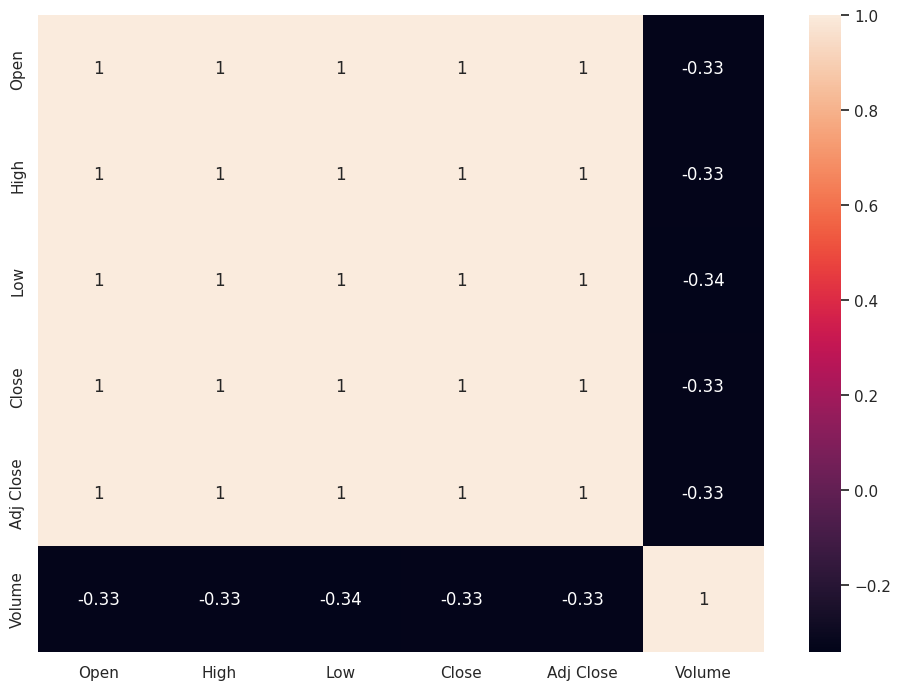

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7, 8.27)})
sns.heatmap(data=correlation_matrix, annot=True);

**DATA CLEANING**

In [ ]:
df_msft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9559 entries, 0 to 9558
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       9559 non-null   object 
 1   Open       9559 non-null   float64
 2   High       9559 non-null   float64
 3   Low        9559 non-null   float64
 4   Close      9559 non-null   float64
 5   Adj Close  9559 non-null   float64
 6   Volume     9559 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 522.9+ KB


In [ ]:
df_msft.Close.value_counts()

Close
0.361111      16
27.250000     13
0.345486      12
2.460938      12
0.359375      12
              ..
33.974998      1
33.134998      1
34.634998      1
34.744999      1
406.559998     1
Name: count, Length: 5828, dtype: int64

<Axes: >

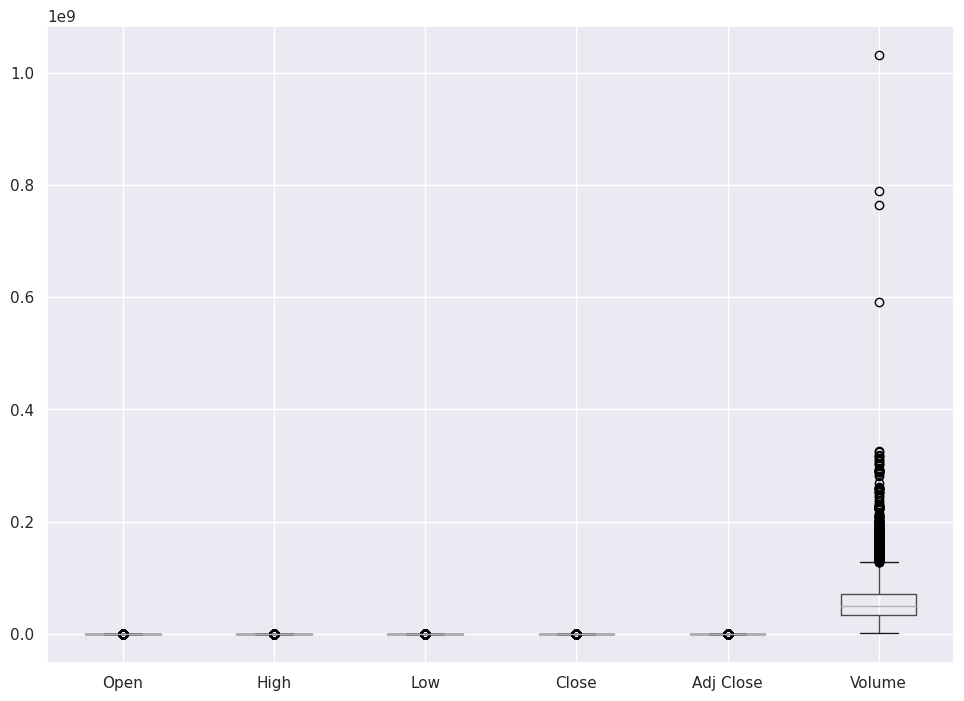

In [ ]:
df_msft.boxplot()

{'whiskers': [<matplotlib.lines.Line2D at 0x7eec10f06d10>,
 'caps': [<matplotlib.lines.Line2D at 0x7eec10f07250>,
 'boxes': [<matplotlib.lines.Line2D at 0x7eec10f06a70>],
 'medians': [<matplotlib.lines.Line2D at 0x7eec10f07790>],
 'fliers': [<matplotlib.lines.Line2D at 0x7eec10f07a30>],
 'means': []}

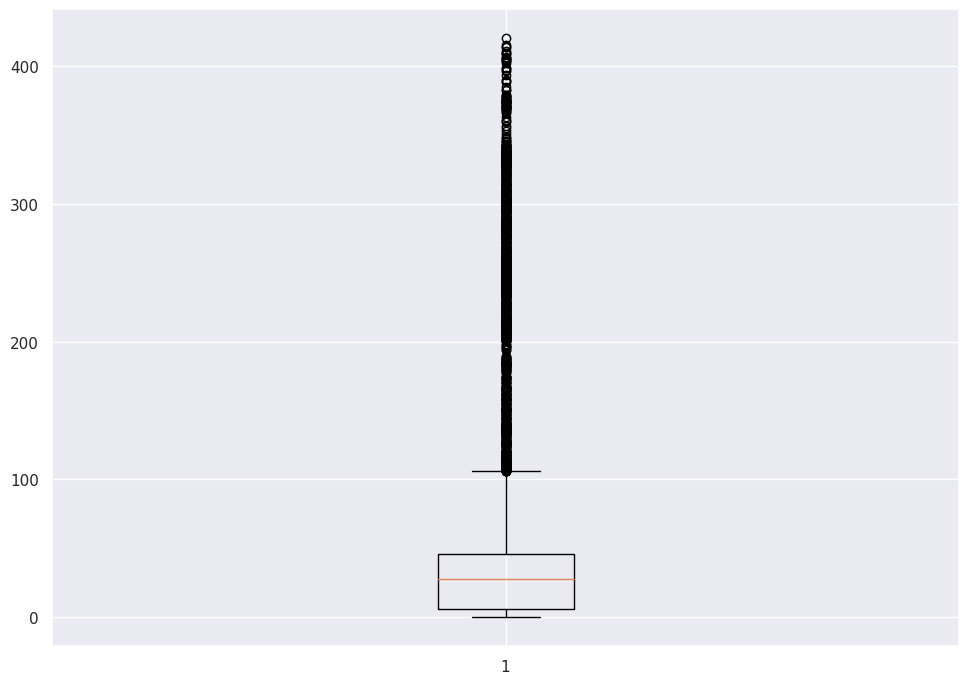

In [ ]:
plt.boxplot(df_msft["Close"])

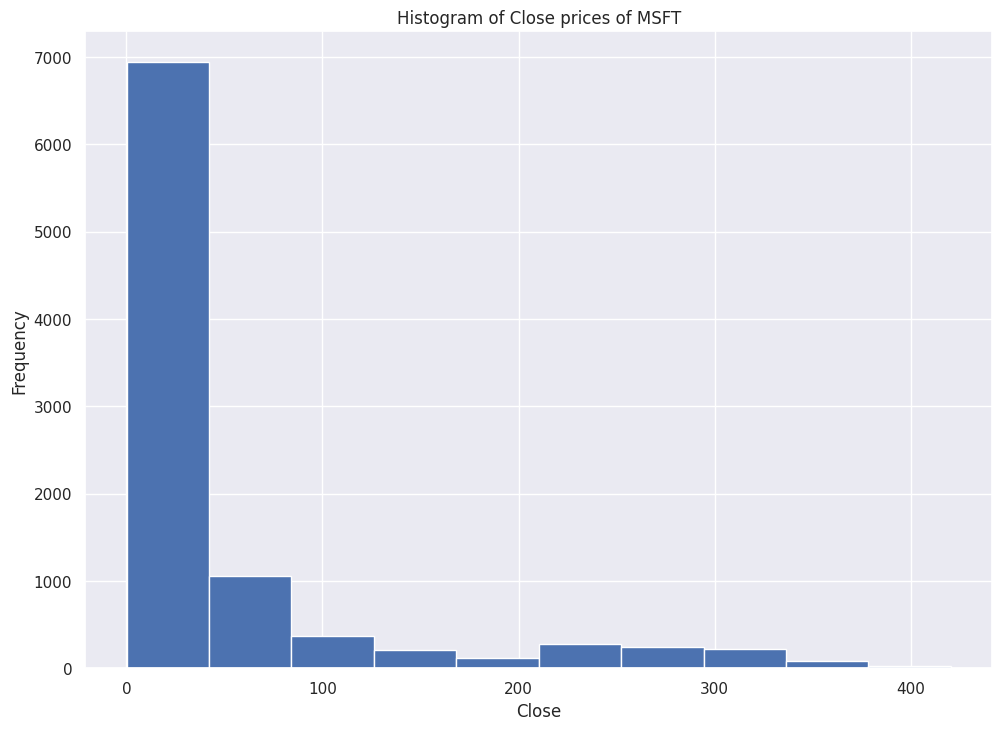

In [ ]:
plt.hist(df_msft["Close"])
plt.xlabel("Close")
plt.ylabel("Frequency")
plt.title(f"Histogram of Close prices of MSFT")
plt.show()

- the data is heavily right skewed, will see if the log transformation will improve prediction accuracy
- a lot of outliers in the "close" feature, but it's time series, if i'll keep the info which aren't outliers, probably will lose relation to recent price changes, but will give it a try anyway
- NO MISSING VALUES
- THE DATA IS CONSISTANT

DATA SCALING:
-STANDARDIZATION
-NORMALIZATION
-ROBUST SCALING

scaling might be needed when we are adding volume and RSI values, rather than that "Close" feature is fine

Create dataset with date and close price only

In [ ]:
df_msftx = df_msft[['Date', 'Close']]

df_msftx

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9554,2024-02-09,420.549988
9555,2024-02-12,415.260010
9556,2024-02-13,406.320007
9557,2024-02-14,409.489990


Putting Date in date format instead of the current string format

In [ ]:
df_msftx['Date']

0       1986-03-13
1       1986-03-14
2       1986-03-17
3       1986-03-18
4       1986-03-19
           ...    
9554    2024-02-09
9555    2024-02-12
9556    2024-02-13
9557    2024-02-14
9558    2024-02-15
Name: Date, Length: 9559, dtype: object

In [ ]:
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-13')
datetime_object

datetime.datetime(1986, 3, 13, 0, 0)

In [ ]:
df_msftx

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9554,2024-02-09,420.549988
9555,2024-02-12,415.260010
9556,2024-02-13,406.320007
9557,2024-02-14,409.489990


The date will be in the correct format

In [ ]:
df_msftx['Date'] = df_msftx['Date'].apply(str_to_datetime)
df_msftx['Date']

<ipython-input-20-04ecb8cb7ccf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_msftx['Date'] = df_msftx['Date'].apply(str_to_datetime)


0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9554   2024-02-09
9555   2024-02-12
9556   2024-02-13
9557   2024-02-14
9558   2024-02-15
Name: Date, Length: 9559, dtype: datetime64[ns]

Replacing the index with the date column

In [ ]:
df_msftx.index = df_msftx.pop('Date')
df_msftx

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2024-02-09,420.549988
2024-02-12,415.260010
2024-02-13,406.320007


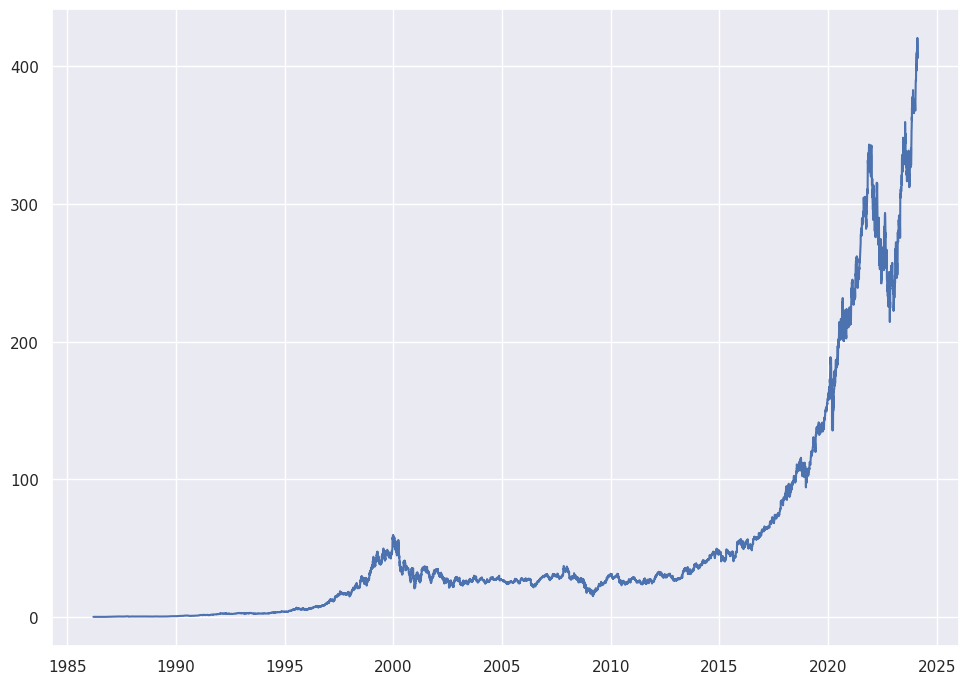

In [ ]:
plt.plot(df_msftx.index, df_msftx['Close'])

In [ ]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

 #Start day second time around: '1986-03-18'
windowed_df = df_to_windowed_df(df_msftx,
                                '1986-03-18',
                                '2022-03-23',
                                n=3)

#2013-04-19





windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,1986-03-18,0.097222,0.100694,0.102431,0.099826
1,1986-03-19,0.100694,0.102431,0.099826,0.098090
2,1986-03-20,0.102431,0.099826,0.098090,0.095486
3,1986-03-21,0.099826,0.098090,0.095486,0.092882
4,1986-03-24,0.098090,0.095486,0.092882,0.090278
...,...,...,...,...,...
9074,2022-03-17,276.440002,287.149994,294.390015,295.220001
9075,2022-03-18,287.149994,294.390015,295.220001,300.429993
9076,2022-03-21,294.390015,295.220001,300.429993,299.160004
9077,2022-03-22,295.220001,300.429993,299.160004,304.059998


In [ ]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]
  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((9079,), (9079, 3, 1), (9079,))

In [ ]:
q_80 = int(len(dates)* 0.8)
q_90 = int(len(dates)* 0.9)

dates_train, x_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, x_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, x_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

In [ ]:
x_train.shape

(7263, 3, 1)

In [ ]:
x_train

array([[[ 0.097222],
        [ 0.100694],
        [ 0.102431]],

       [[ 0.100694],
        [ 0.102431],
        [ 0.099826]],

       [[ 0.102431],
        [ 0.099826],
        [ 0.09809 ]],

       ...,

       [[47.45    ],
        [47.02    ],
        [46.45    ]],

       [[47.02    ],
        [46.45    ],
        [46.76    ]],

       [[46.45    ],
        [46.76    ],
        [46.33    ]]], dtype=float32)

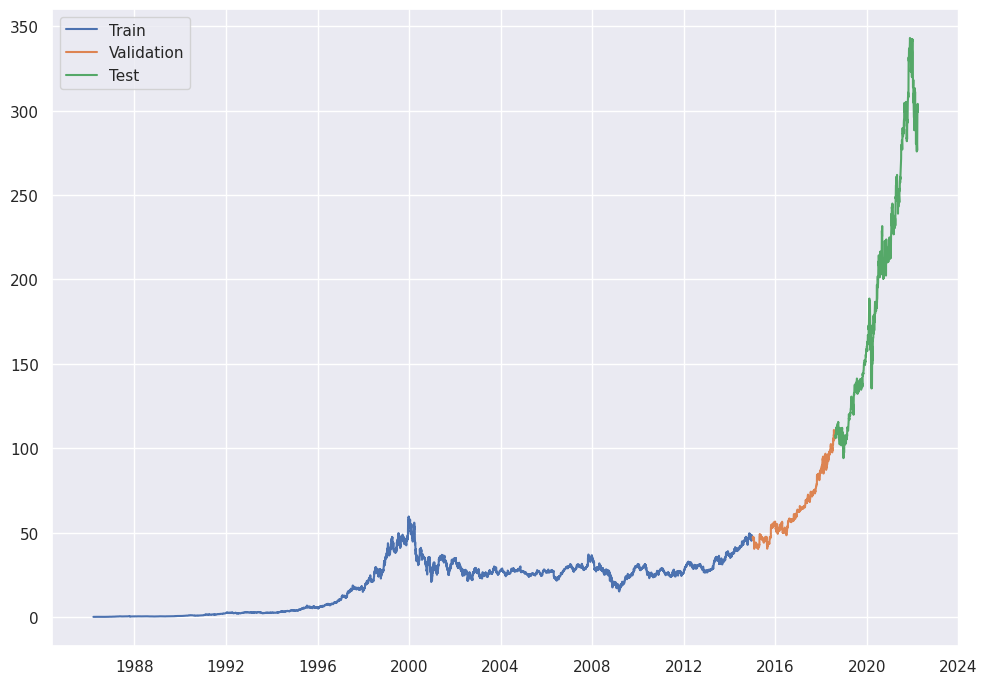

In [ ]:
plt.plot(dates_train,y_train)
plt.plot(dates_val,y_val)
plt.plot(dates_test,y_test)
plt.legend(['Train', 'Validation', 'Test'])

In [ ]:
model = Sequential([layers.Input((3,1)),
                    layers.LSTM(64),
                    layers.Dense(128, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)
                    ])
model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error']
              )

model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs= 100)

Epoch 1/100
227/227 [==============================] - 4s 7ms/step - loss: 93.2614 - mean_absolute_error: 4.2136 - val_loss: 500.2928 - val_mean_absolute_error: 14.7868
Epoch 2/100
227/227 [==============================] - 1s 5ms/step - loss: 0.3479 - mean_absolute_error: 0.3270 - val_loss: 393.4311 - val_mean_absolute_error: 12.3736
Epoch 3/100
227/227 [==============================] - 1s 5ms/step - loss: 0.3199 - mean_absolute_error: 0.3254 - val_loss: 356.9010 - val_mean_absolute_error: 11.5906
Epoch 4/100
227/227 [==============================] - 1s 6ms/step - loss: 0.3066 - mean_absolute_error: 0.3189 - val_loss: 328.4875 - val_mean_absolute_error: 10.8572
Epoch 5/100
227/227 [==============================] - 1s 5ms/step - loss: 0.3415 - mean_absolute_error: 0.3457 - val_loss: 324.0159 - val_mean_absolute_error: 10.8522
Epoch 6/100
227/227 [==============================] - 1s 5ms/step - loss: 0.3286 - mean_absolute_error: 0.3397 - val_loss: 309.5716 - val_mean_absolute_error:

accuracy 6.7207 till 2022, three days

227/227 [==============================] - 1s 3ms/step


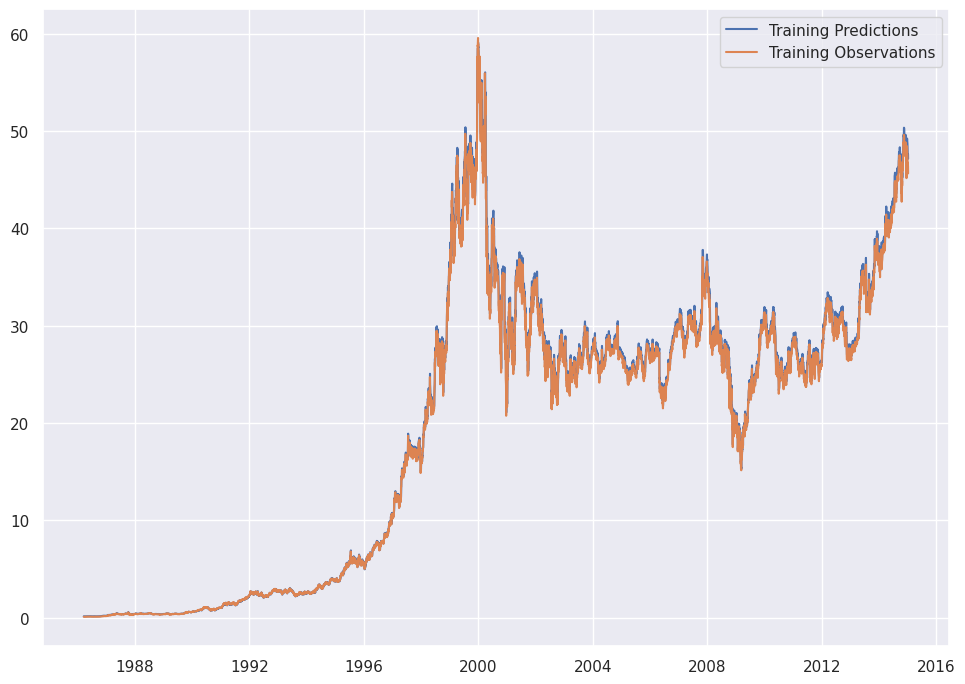

In [ ]:
train_predictions = model.predict(x_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

29/29 [==============================] - 0s 3ms/step


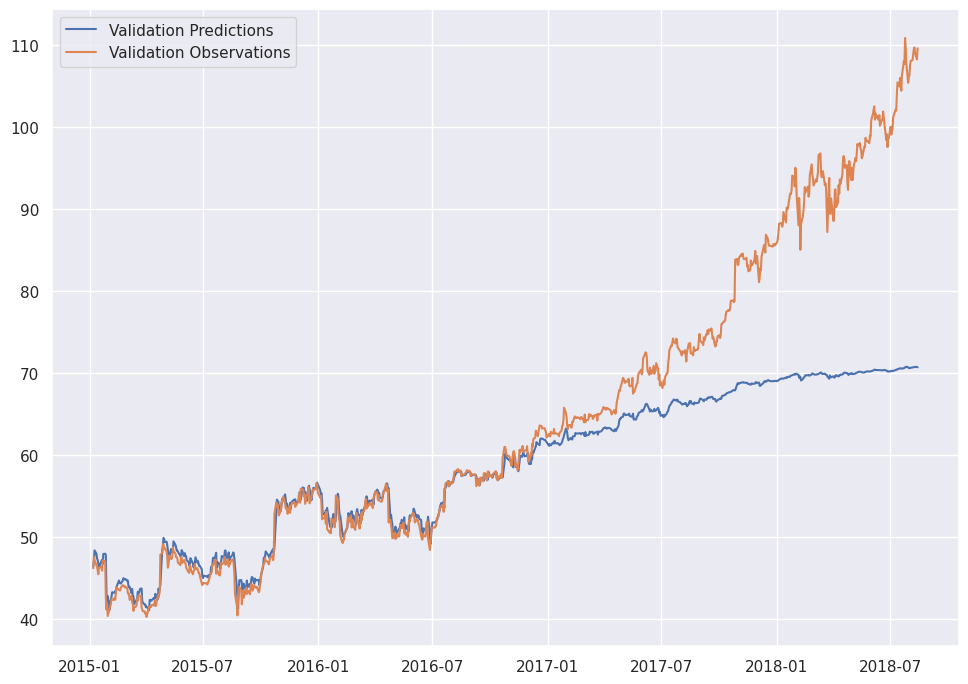

In [ ]:
val_predictions = model.predict(x_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

29/29 [==============================] - 0s 3ms/step


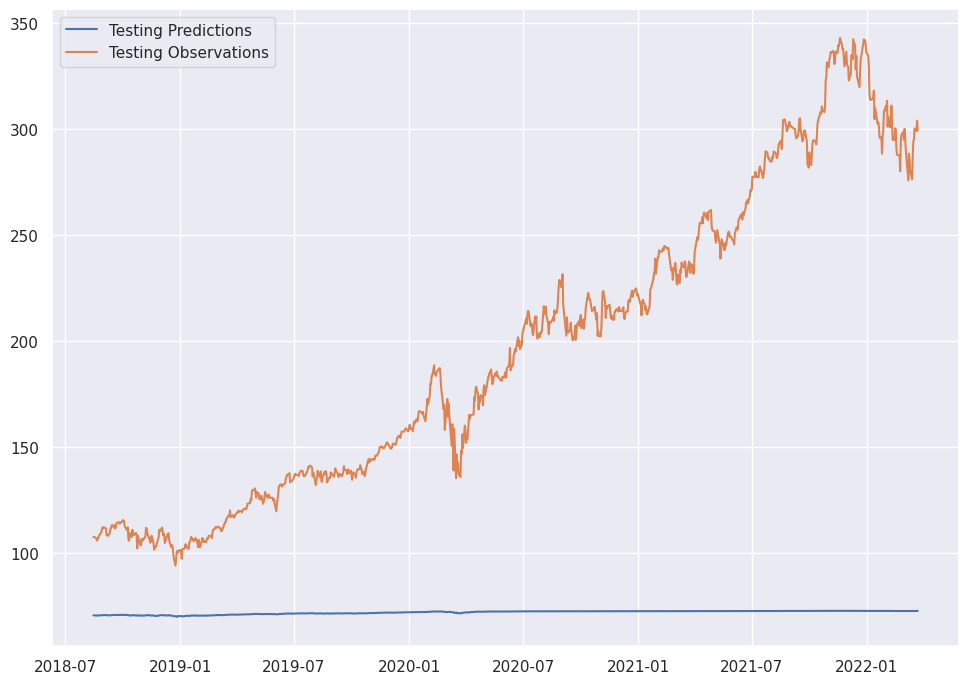

In [ ]:
test_predictions = model.predict(x_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

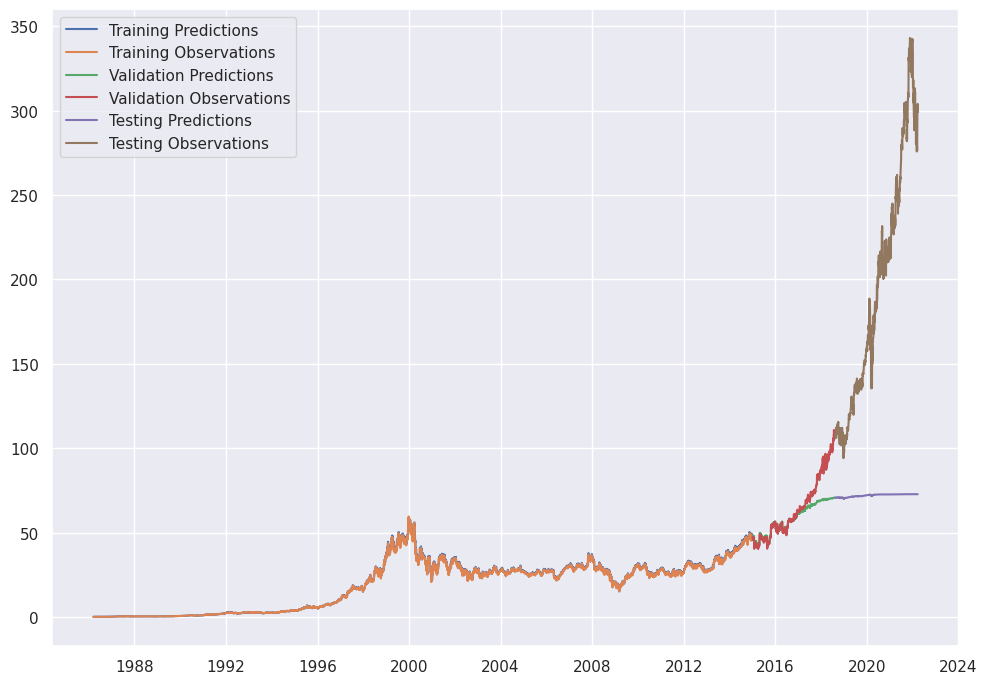

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

Removing outliers from "Close"
and retrying the model



In [ ]:
df_filtered = df_msftx[df_msftx['Close'] <= 30]

{'whiskers': [<matplotlib.lines.Line2D at 0x7eebf2d0fb20>,
 'caps': [<matplotlib.lines.Line2D at 0x7eebf2d0e710>,
 'boxes': [<matplotlib.lines.Line2D at 0x7eebf2d0f880>],
 'medians': [<matplotlib.lines.Line2D at 0x7eebf2d344c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7eebf2d34760>],
 'means': []}

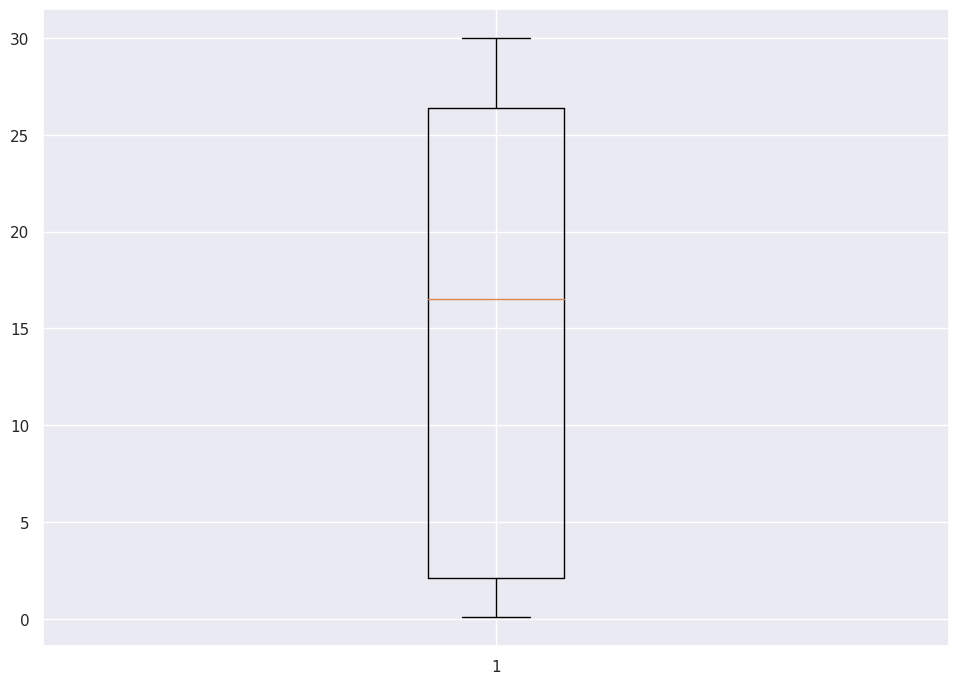

In [ ]:
plt.boxplot(df_filtered["Close"])

In [ ]:
df_filtered

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2013-04-15,28.690001
2013-04-16,28.969999
2013-04-17,28.830000


In [ ]:
windowed_df_filtered = df_to_windowed_df(df_msftx,
                                '1986-03-18',
                                '2013-04-19',
                                n=3)




windowed_df_filtered

,Target Date,Target-3,Target-2,Target-1,Target
0,1986-03-18,0.097222,0.100694,0.102431,0.099826
1,1986-03-19,0.100694,0.102431,0.099826,0.098090
2,1986-03-20,0.102431,0.099826,0.098090,0.095486
3,1986-03-21,0.099826,0.098090,0.095486,0.092882
4,1986-03-24,0.098090,0.095486,0.092882,0.090278
...,...,...,...,...,...
6826,2013-04-15,30.280001,28.940001,28.790001,28.690001
6827,2013-04-16,28.940001,28.790001,28.690001,28.969999
6828,2013-04-17,28.790001,28.690001,28.969999,28.830000
6829,2013-04-18,28.690001,28.969999,28.830000,28.790001


FIRST MODEL EDITED, WITHOUT OUTLIERS
IT WILL COVER THE DATA UNTIL 2013

In [ ]:
dates_edited, x_edited, y_edited = windowed_df_to_date_X_y(windowed_df_filtered)

dates_edited.shape, x_edited.shape, y_edited.shape

((6831,), (6831, 3, 1), (6831,))

In [ ]:
q_edited_80 = int(len(dates_edited)* 0.8)
q_edited_90 = int(len(dates_edited)* 0.9)

dates_edited_train, x_edited_train, y_edited_train = dates_edited[:q_edited_80], x_edited[:q_edited_80], y_edited[:q_edited_80]
dates_edited_val, x_edited_val, y_edited_val = dates_edited[q_edited_80:q_edited_90], x_edited[q_edited_80:q_edited_90], y_edited[q_edited_80:q_edited_90]
dates_edited_test, x_edited_test, y_edited_test = dates_edited[q_edited_90:], x_edited[q_edited_90:], y_edited[q_edited_90:]

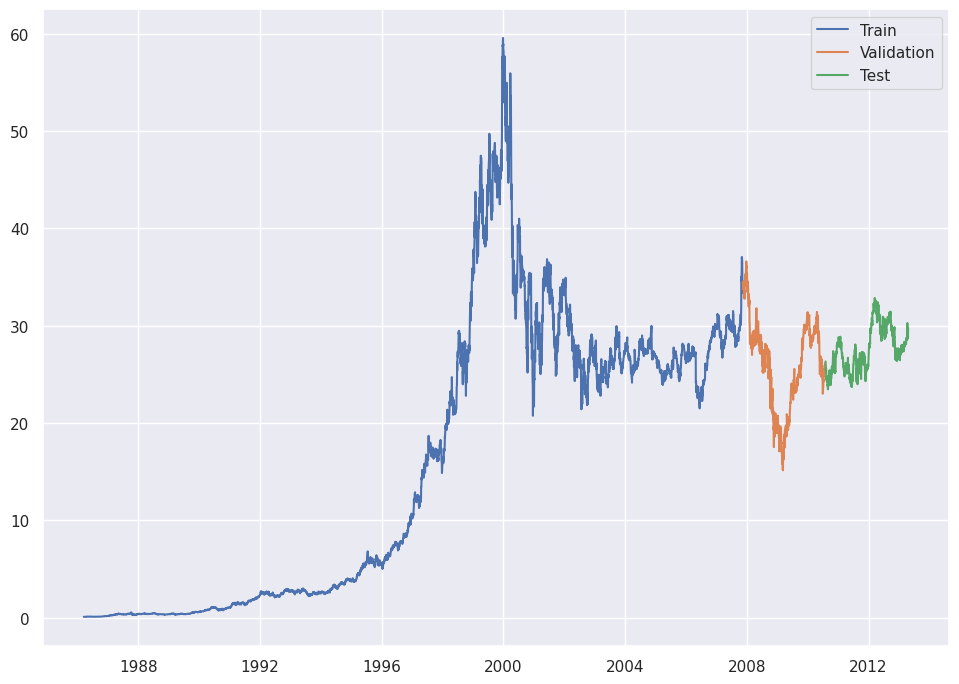

In [ ]:
plt.plot(dates_edited_train,y_edited_train)
plt.plot(dates_edited_val,y_edited_val)
plt.plot(dates_edited_test,y_edited_test)
plt.legend(['Train', 'Validation', 'Test'])

In [ ]:
model.fit(x_edited_train, y_edited_train, validation_data=(x_edited_val, y_edited_val), epochs= 100)

Epoch 1/100
171/171 [==============================] - 1s 5ms/step - loss: 0.2776 - mean_absolute_error: 0.2757 - val_loss: 0.5198 - val_mean_absolute_error: 0.5627
Epoch 2/100
171/171 [==============================] - 1s 5ms/step - loss: 0.2666 - mean_absolute_error: 0.2688 - val_loss: 0.4261 - val_mean_absolute_error: 0.5021
Epoch 3/100
171/171 [==============================] - 1s 5ms/step - loss: 0.2781 - mean_absolute_error: 0.2767 - val_loss: 0.4297 - val_mean_absolute_error: 0.4869
Epoch 4/100
171/171 [==============================] - 1s 5ms/step - loss: 0.3154 - mean_absolute_error: 0.2984 - val_loss: 0.3598 - val_mean_absolute_error: 0.4351
Epoch 5/100
171/171 [==============================] - 1s 5ms/step - loss: 0.2828 - mean_absolute_error: 0.2778 - val_loss: 0.3452 - val_mean_absolute_error: 0.4231
Epoch 6/100
171/171 [==============================] - 1s 4ms/step - loss: 0.2969 - mean_absolute_error: 0.2928 - val_loss: 0.3506 - val_mean_absolute_error: 0.4271
Epoch 7/10

171/171 [==============================] - 0s 3ms/step


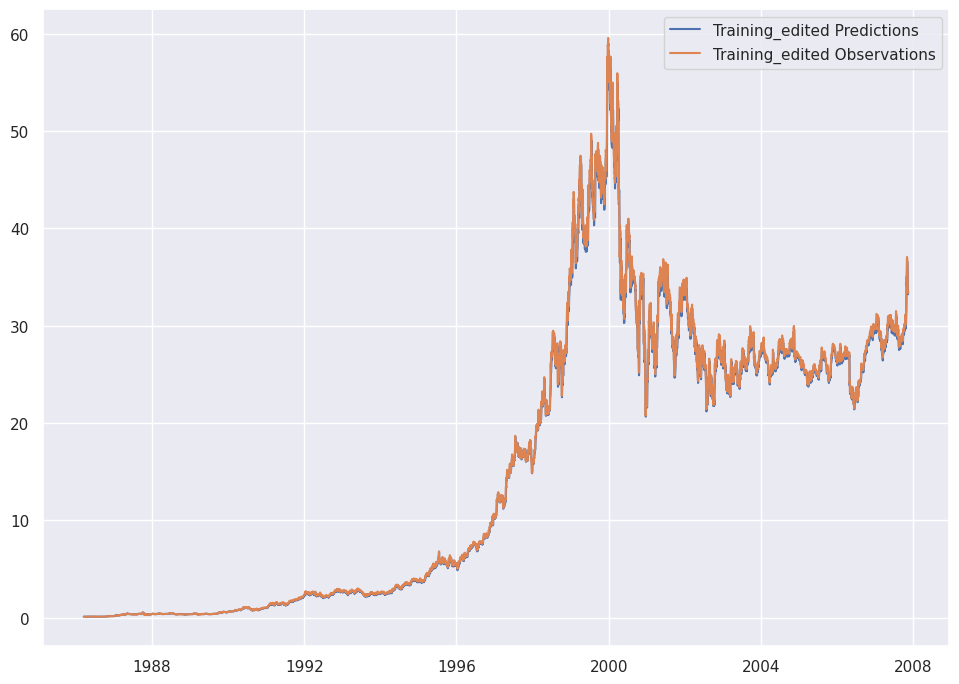

In [ ]:
train_edited_predictions = model.predict(x_edited_train).flatten()

plt.plot(dates_edited_train, train_edited_predictions)
plt.plot(dates_edited_train, y_edited_train)
plt.legend(['Training_edited Predictions', 'Training_edited Observations'])

22/22 [==============================] - 0s 3ms/step


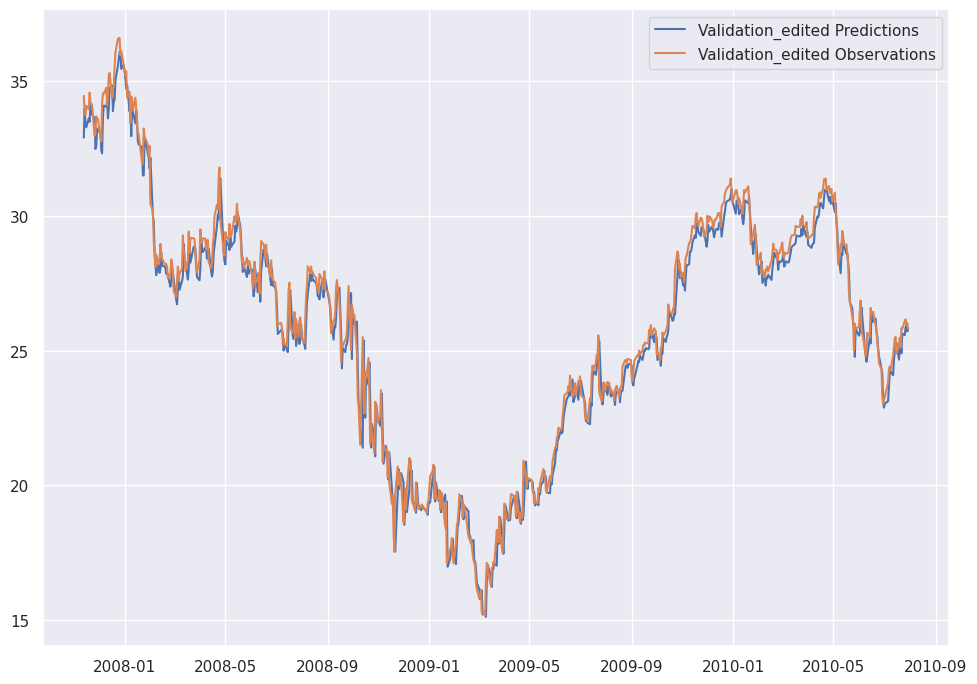

In [ ]:
val_edited_predictions = model.predict(x_edited_val).flatten()

plt.plot(dates_edited_val, val_edited_predictions)
plt.plot(dates_edited_val, y_edited_val)
plt.legend(['Validation_edited Predictions', 'Validation_edited Observations'])

22/22 [==============================] - 0s 2ms/step


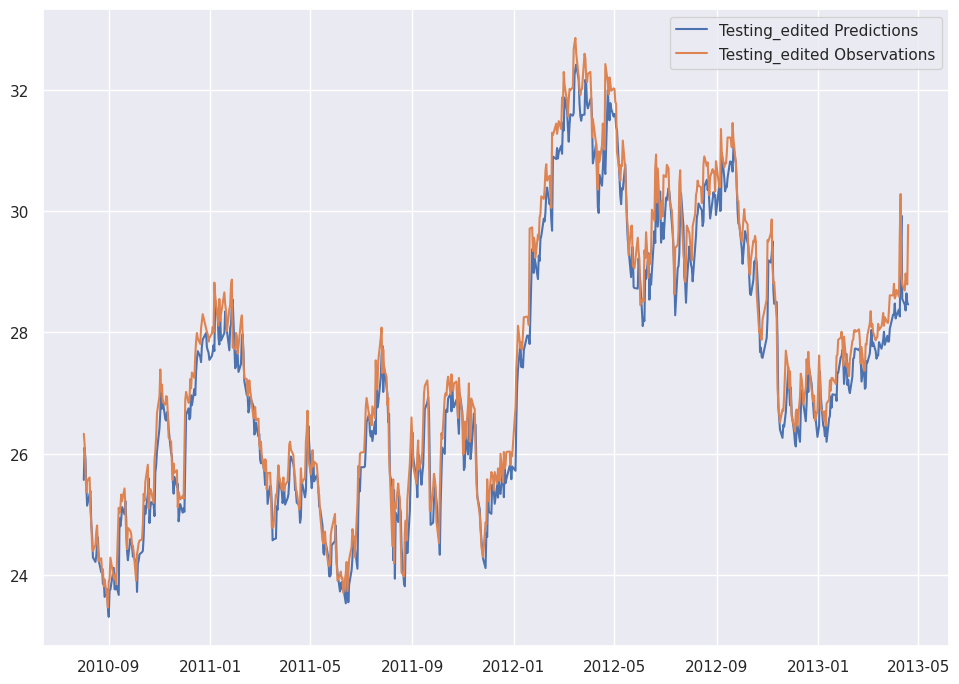

In [ ]:
test_edited_predictions = model.predict(x_edited_test).flatten()

plt.plot(dates_edited_test, test_edited_predictions)
plt.plot(dates_edited_test, y_edited_test)
plt.legend(['Testing_edited Predictions', 'Testing_edited Observations'])

Clearly that edited version gives amazing results but is it ends at 2013, so the question is.. is it useful?

Choose different section of data

In [ ]:
# Start day second time around: '2021-03-25'
windowed_df_2 = df_to_windowed_df(df_msftx,
                                '2021-03-25',
                                '2022-03-23',
                                n=3)
windowed_df_2

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,235.990005,237.580002,235.460007,232.339996
1,2021-03-26,237.580002,235.460007,232.339996,236.479996
2,2021-03-29,235.460007,232.339996,236.479996,235.240005
3,2021-03-30,232.339996,236.479996,235.240005,231.850006
4,2021-03-31,236.479996,235.240005,231.850006,235.770004
...,...,...,...,...,...
247,2022-03-17,276.440002,287.149994,294.390015,295.220001
248,2022-03-18,287.149994,294.390015,295.220001,300.429993
249,2022-03-21,294.390015,295.220001,300.429993,299.160004
250,2022-03-22,295.220001,300.429993,299.160004,304.059998


In [ ]:
dates_2, x_2, y_2 = windowed_df_to_date_X_y(windowed_df_2)

dates_2.shape, x_2.shape, y_2.shape

((252,), (252, 3, 1), (252,))

In [ ]:
q_2_80 = int(len(dates_2)* 0.8)
q_2_90 = int(len(dates_2)* 0.9)

dates_2_train, x_2_train, y_2_train = dates_2[:q_2_80], x_2[:q_2_80], y_2[:q_2_80]
dates_2_val, x_2_val, y_2_val = dates_2[q_2_80:q_2_90], x_2[q_2_80:q_2_90], y_2[q_2_80:q_2_90]
dates_2_test, x_2_test, y_2_test = dates_2[q_2_90:], x_2[q_2_90:], y_2[q_2_90:]

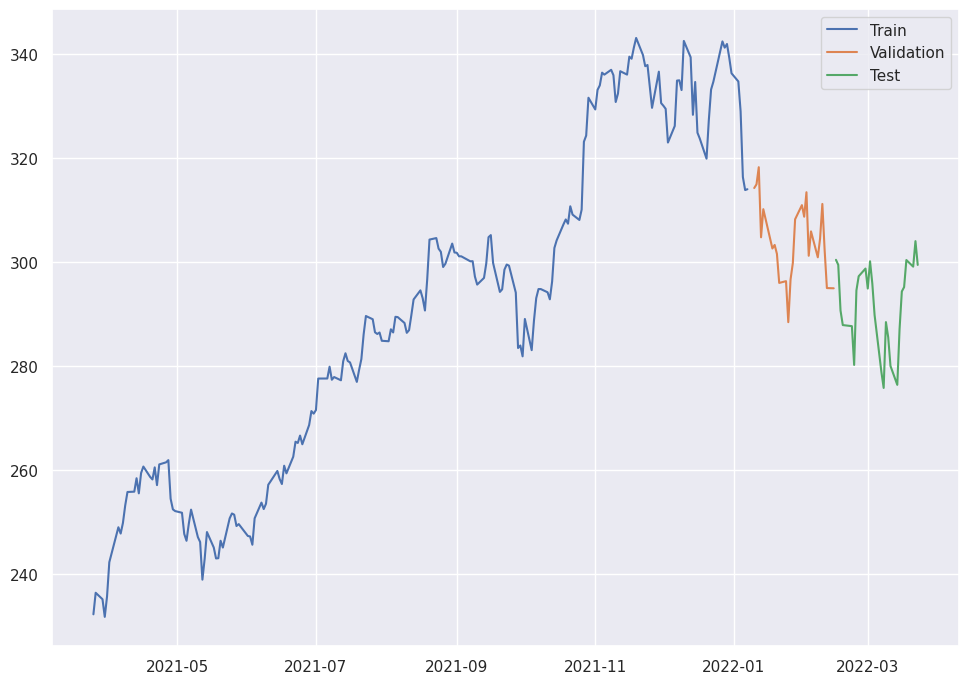

In [ ]:
plt.plot(dates_2_train,y_2_train)
plt.plot(dates_2_val,y_2_val)
plt.plot(dates_2_test,y_2_test)
plt.legend(['Train', 'Validation', 'Test'])

In [ ]:
model.fit(x_2_train, y_2_train, validation_data=(x_2_val, y_2_val), epochs= 100)

Epoch 1/100
7/7 [==============================] - 0s 60ms/step - loss: 37329.7969 - mean_absolute_error: 190.1277 - val_loss: 23307.1230 - val_mean_absolute_error: 152.4931
Epoch 2/100
7/7 [==============================] - 0s 9ms/step - loss: 10011.6387 - mean_absolute_error: 89.5880 - val_loss: 319.5367 - val_mean_absolute_error: 16.3269
Epoch 3/100
7/7 [==============================] - 0s 8ms/step - loss: 3146.6033 - mean_absolute_error: 45.5246 - val_loss: 2955.7051 - val_mean_absolute_error: 53.8770
Epoch 4/100
7/7 [==============================] - 0s 8ms/step - loss: 3734.9668 - mean_absolute_error: 52.0102 - val_loss: 61.3848 - val_mean_absolute_error: 6.2714
Epoch 5/100
7/7 [==============================] - 0s 9ms/step - loss: 1138.7311 - mean_absolute_error: 28.6459 - val_loss: 1676.5110 - val_mean_absolute_error: 40.2932
Epoch 6/100
7/7 [==============================] - 0s 8ms/step - loss: 1679.5109 - mean_absolute_error: 33.5120 - val_loss: 1182.7191 - val_mean_absolute

7/7 [==============================] - 0s 3ms/step


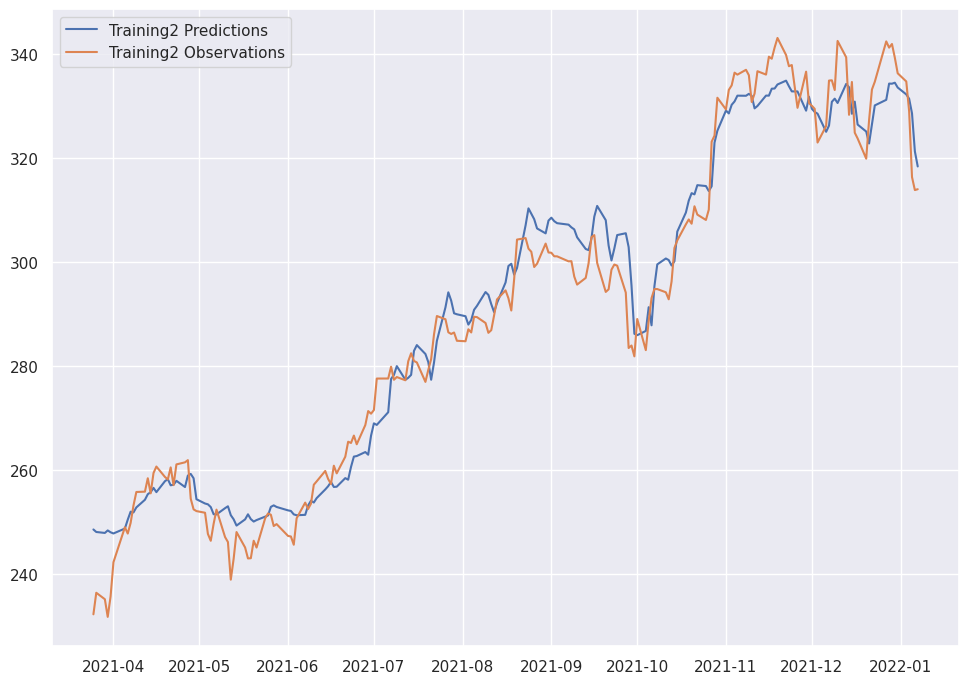

In [ ]:
train_2_predictions = model.predict(x_2_train).flatten()

plt.plot(dates_2_train, train_2_predictions)
plt.plot(dates_2_train, y_2_train)
plt.legend(['Training2 Predictions', 'Training2 Observations'])

1/1 [==============================] - 0s 20ms/step


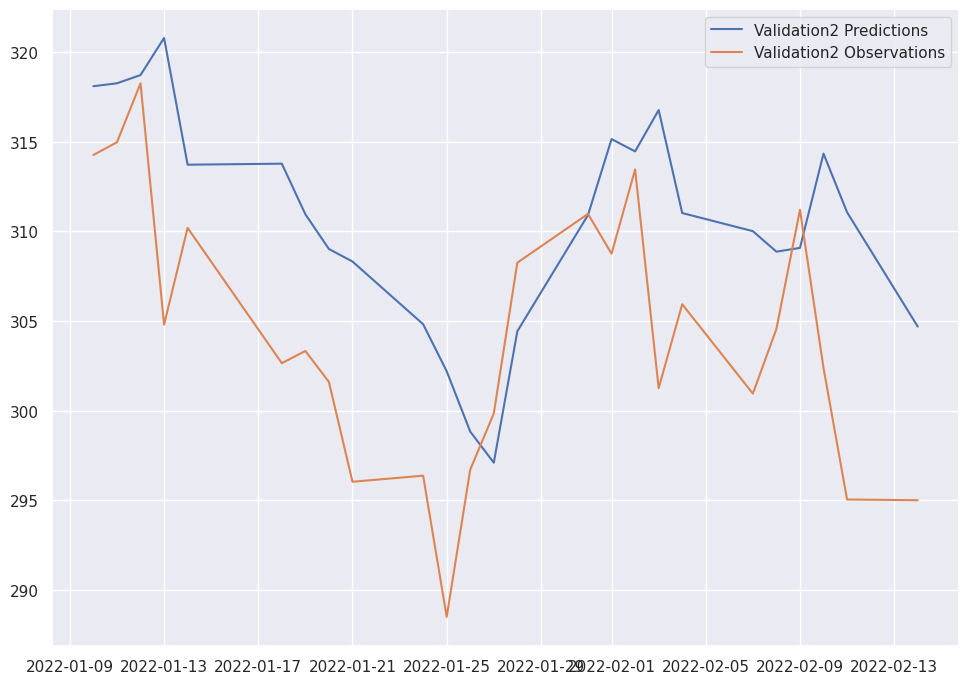

In [ ]:
val_2_predictions = model.predict(x_2_val).flatten()

plt.plot(dates_2_val, val_2_predictions)
plt.plot(dates_2_val, y_2_val)
plt.legend(['Validation2 Predictions', 'Validation2 Observations'])

1/1 [==============================] - 0s 17ms/step


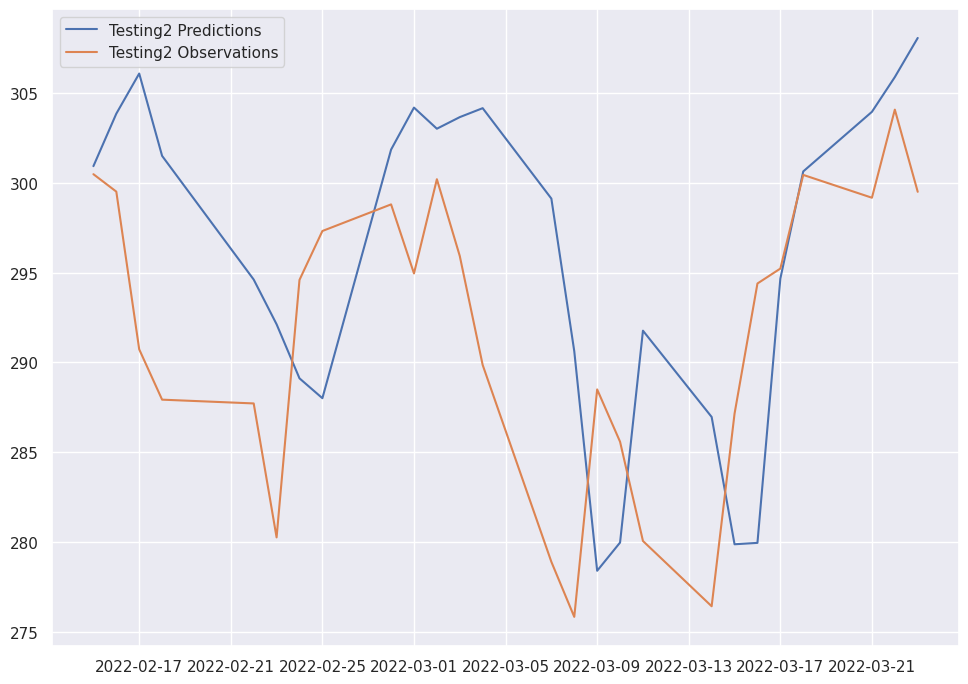

In [ ]:
test_2_predictions = model.predict(x_2_test).flatten()

plt.plot(dates_2_test, test_2_predictions)
plt.plot(dates_2_test, y_2_test)
plt.legend(['Testing2 Predictions', 'Testing2 Observations'])

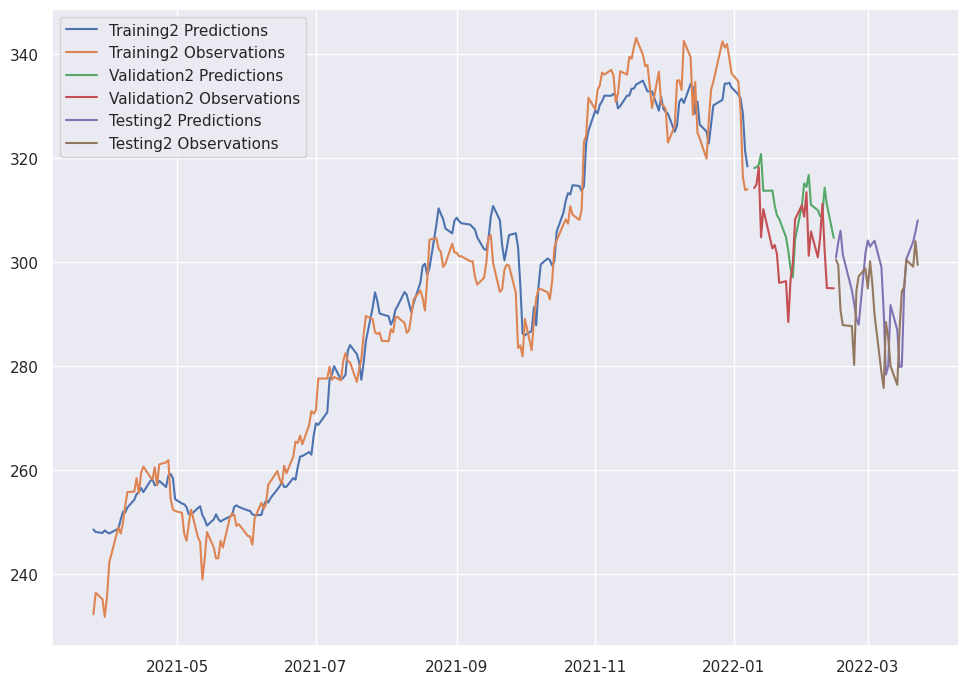

In [ ]:
plt.plot(dates_2_train, train_2_predictions)
plt.plot(dates_2_train, y_2_train)
plt.plot(dates_2_val, val_2_predictions)
plt.plot(dates_2_val, y_2_val)
plt.plot(dates_2_test, test_2_predictions)
plt.plot(dates_2_test, y_2_test)
plt.legend(['Training2 Predictions',
            'Training2 Observations',
            'Validation2 Predictions',
            'Validation2 Observations',
            'Testing2 Predictions',
            'Testing2 Observations'])

In [ ]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_2_val, dates_2_test])

for target_date in recursive_dates:
  last_window = deepcopy(x_2_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 18ms/step


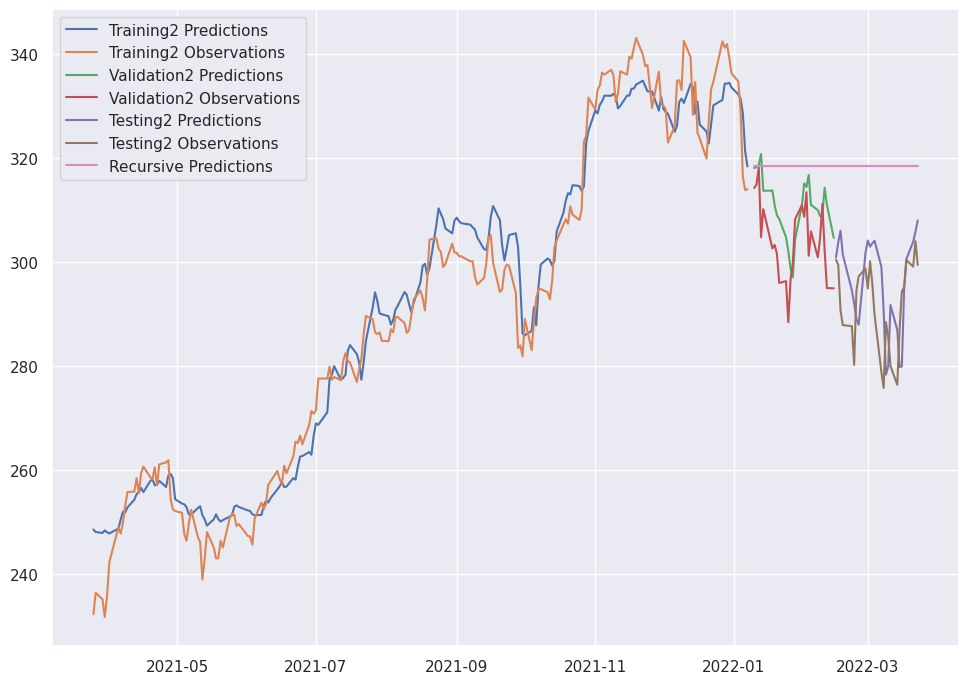

In [ ]:
plt.plot(dates_2_train, train_2_predictions)
plt.plot(dates_2_train, y_2_train)
plt.plot(dates_2_val, val_2_predictions)
plt.plot(dates_2_val, y_2_val)
plt.plot(dates_2_test, test_2_predictions)
plt.plot(dates_2_test, y_2_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training2 Predictions',
            'Training2 Observations',
            'Validation2 Predictions',
            'Validation2 Observations',
            'Testing2 Predictions',
            'Testing2 Observations',
            'Recursive Predictions'])

**MODEL 2 MSFT WITH RSI**

In [ ]:



# Assuming you have separate DataFrames for MSFT prices (df_price) and RSI (df_rsi)
#merged_data = df_price.merge(df_rsi, on='date')  # Merge by date column
#X_train, X_val, X_test, y_train, y_val, y_test = split_data(merged_data)  # Split data

# Train your LSTM model using X_train, X_val, X_test, y_train, y_val, y_test

rsi_msft


,Date,Open,High,Low,Close,Adj Close,Volume,RSI
0,11/15/1999,44.125000,44.250000,43.468750,43.500000,26.918644,47080400,25.0233
1,11/16/1999,43.468750,43.875000,42.937500,43.656250,27.015339,59165200,27.3510
2,11/17/1999,43.218750,43.531250,42.500000,42.500000,26.299820,66819000,21.7581
3,11/18/1999,42.468750,42.906250,42.250000,42.468750,26.280487,64493200,21.6304
4,11/19/1999,42.218750,43.281250,42.187500,43.000000,26.609240,58226000,29.7238
...,...,...,...,...,...,...,...,...
6097,2/9/2024,415.250000,420.820007,415.089996,420.549988,419.773712,22032800,72.7808
6098,2/12/2024,420.559998,420.739990,414.750000,415.260010,414.493500,21202900,63.8790
6099,2/13/2024,404.940002,410.070007,403.390015,406.320007,405.570007,27824900,51.9481
6100,2/14/2024,408.070007,409.839996,404.570007,409.489990,409.489990,20401200,55.9559


In [ ]:
rsi_msftx = rsi_msft[['Date', 'Close', 'RSI']]

rsi_msftx

,Date,Close,RSI
0,11/15/1999,43.500000,25.0233
1,11/16/1999,43.656250,27.3510
2,11/17/1999,42.500000,21.7581
3,11/18/1999,42.468750,21.6304
4,11/19/1999,43.000000,29.7238
...,...,...,...
6097,2/9/2024,420.549988,72.7808
6098,2/12/2024,415.260010,63.8790
6099,2/13/2024,406.320007,51.9481
6100,2/14/2024,409.489990,55.9559


In [ ]:
rsi_msftx['Date']

0       11/15/1999
1       11/16/1999
2       11/17/1999
3       11/18/1999
4       11/19/1999
           ...    
6097      2/9/2024
6098     2/12/2024
6099     2/13/2024
6100     2/14/2024
6101     2/15/2024
Name: Date, Length: 6102, dtype: object

In [ ]:
rsi_msftx['Date'] = pd.to_datetime(rsi_msft['Date'])



<ipython-input-60-fccb76bb2327>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rsi_msftx['Date'] = pd.to_datetime(rsi_msft['Date'])


In [ ]:
rsi_msftx.index = rsi_msftx.pop('Date')
rsi_msftx

,Close,RSI
Date,,
1999-11-15,43.500000,25.0233
1999-11-16,43.656250,27.3510
1999-11-17,42.500000,21.7581
1999-11-18,42.468750,21.6304
1999-11-19,43.000000,29.7238
...,...,...
2024-02-09,420.549988,72.7808
2024-02-12,415.260010,63.8790
2024-02-13,406.320007,51.9481


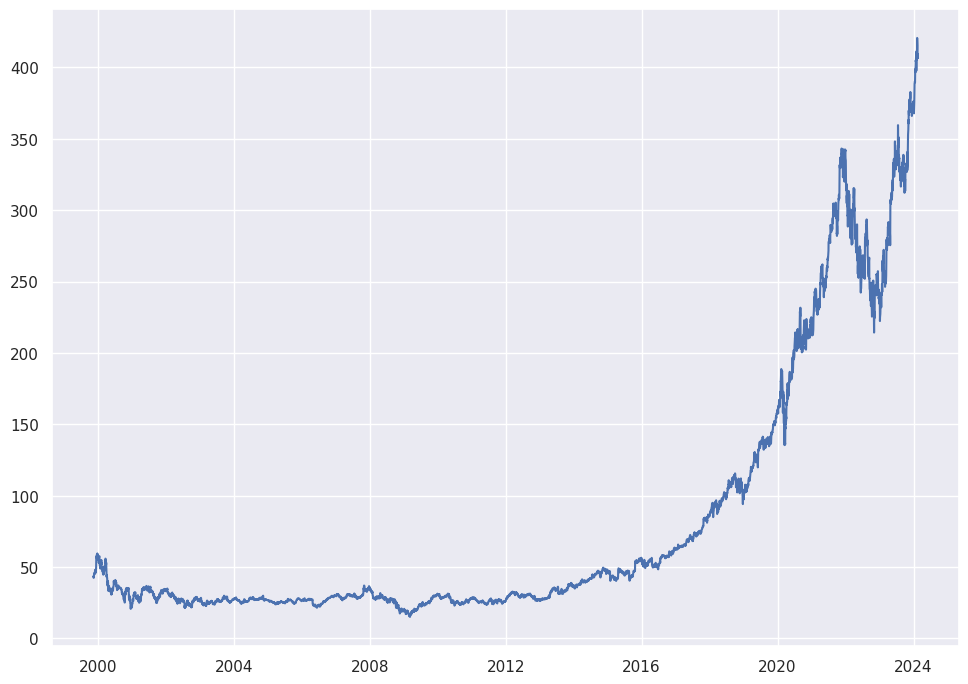

In [ ]:
plt.plot(rsi_msftx.index, rsi_msftx['Close'])

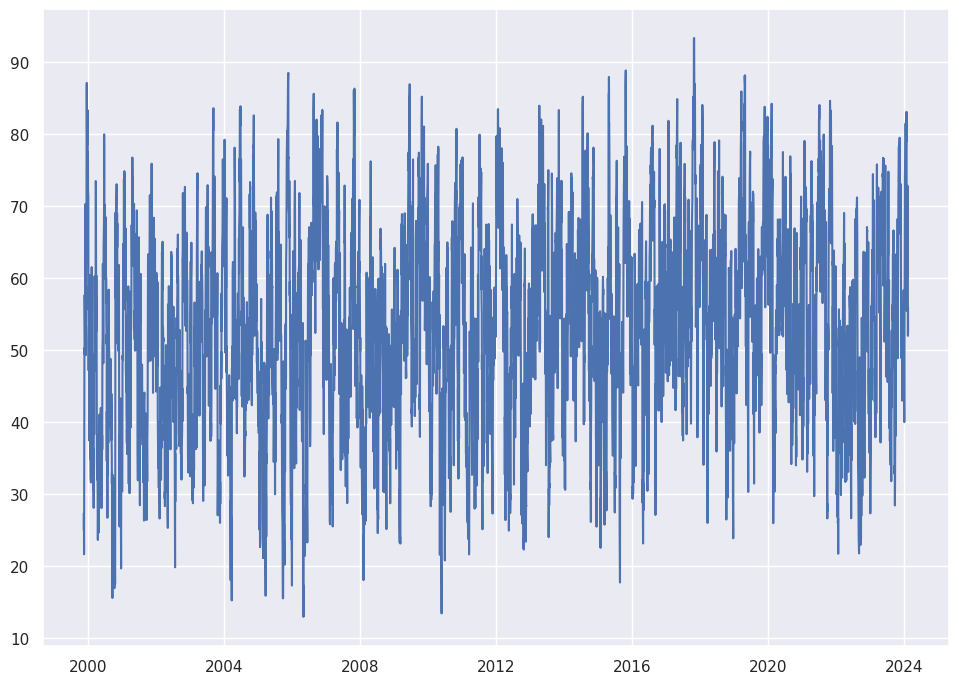

In [ ]:
plt.plot(rsi_msftx.index, rsi_msftx['RSI'])

In [ ]:
windowed_rsi = rsi_msftx.filter(['Close', 'RSI'])

windowed_rsi


,Close,RSI
Date,,
1999-11-15,43.500000,25.0233
1999-11-16,43.656250,27.3510
1999-11-17,42.500000,21.7581
1999-11-18,42.468750,21.6304
1999-11-19,43.000000,29.7238
...,...,...
2024-02-09,420.549988,72.7808
2024-02-12,415.260010,63.8790
2024-02-13,406.320007,51.9481


In [ ]:
windowed_rsi_np = windowed_rsi.values

windowed_rsi_np

array([[ 43.5     ,  25.0233  ],
       [ 43.65625 ,  27.351   ],
       [ 42.5     ,  21.7581  ],
       ...,
       [406.320007,  51.9481  ],
       [409.48999 ,  55.9559  ],
       [406.559998,  52.3248  ]])

In [ ]:
windowed_rsi_np.shape

(6102, 2)

In [ ]:
training_len = math.ceil(len(windowed_rsi_np) * .8)
val_len = math.ceil(len(windowed_rsi_np) * .9)


training_data = windowed_rsi_np[0:training_len, :]
val_data = windowed_rsi_np[training_len:val_len, :]
test_data = windowed_rsi_np[val_len:, :]
x_train_rsi = []
y_train_rsi = []
x_val_rsi = []
y_val_rsi = []
x_test_rsi = []
y_test_rsi = []


for i in range(3, len(training_data)):
  x_train_rsi.append(training_data[i-3:i])
  y_train_rsi.append(training_data[i, 0])
  if i <= 3:
    print(x_train_rsi)
    print(y_train_rsi)
    print()

for i in range(3, len(val_data)):
  x_val_rsi.append(val_data[i-3:i])
  y_val_rsi.append(val_data[i, 0])

for i in range(3,len(test_data)):
  x_test_rsi.append(test_data[i-3:i])
  y_test_rsi.append(test_data[i, 0])

[array([[43.5    , 25.0233 ],
       [43.65625, 27.351  ],
       [42.5    , 21.7581 ]])]
[42.46875]



In [ ]:
x_train_rsi, y_train_rsi = np.array(x_train_rsi), np.array(y_train_rsi)
x_val_rsi, y_val_rsi = np.array(x_val_rsi), np.array(y_val_rsi)
x_test_rsi, y_test_rsi = np.array(x_test_rsi), np.array(y_test_rsi)

In [ ]:
x_train_rsi.shape

(4879, 3, 2)

In [ ]:
x_train_rsi

array([[[ 43.5     ,  25.0233  ],
        [ 43.65625 ,  27.351   ],
        [ 42.5     ,  21.7581  ]],

       [[ 43.65625 ,  27.351   ],
        [ 42.5     ,  21.7581  ],
        [ 42.46875 ,  21.6304  ]],

       [[ 42.5     ,  21.7581  ],
        [ 42.46875 ,  21.6304  ],
        [ 43.      ,  29.7238  ]],

       ...,

       [[119.360001,  65.9346  ],
        [119.889999,  68.1258  ],
        [119.93    ,  68.2968  ]],

       [[119.889999,  68.1258  ],
        [119.93    ,  68.2968  ],
        [119.279999,  62.2653  ]],

       [[119.93    ,  68.2968  ],
        [119.279999,  62.2653  ],
        [120.190002,  66.823   ]]])

In [ ]:
y_train_rsi.shape

(4879,)

In [ ]:
y_train_rsi

array([ 42.46875 ,  43.      ,  44.90625 , ..., 119.279999, 120.190002,
       120.330002])

In [ ]:
model_2 = Sequential([layers.Input((3,2)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)
                    ])
model_2.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error']
              )

In [ ]:
model_2.fit(x_train_rsi, y_train_rsi, validation_data=(x_val_rsi, y_val_rsi), epochs= 100)

Epoch 1/100
153/153 [==============================] - 3s 7ms/step - loss: 654.9712 - mean_absolute_error: 16.6323 - val_loss: 15433.1963 - val_mean_absolute_error: 110.1921
Epoch 2/100
153/153 [==============================] - 1s 5ms/step - loss: 3.2643 - mean_absolute_error: 1.0606 - val_loss: 11389.0469 - val_mean_absolute_error: 89.6714
Epoch 3/100
153/153 [==============================] - 1s 5ms/step - loss: 1.1709 - mean_absolute_error: 0.7217 - val_loss: 10702.2871 - val_mean_absolute_error: 86.2728
Epoch 4/100
153/153 [==============================] - 1s 5ms/step - loss: 0.9360 - mean_absolute_error: 0.6422 - val_loss: 10130.7383 - val_mean_absolute_error: 83.5234
Epoch 5/100
153/153 [==============================] - 1s 5ms/step - loss: 0.8800 - mean_absolute_error: 0.6267 - val_loss: 9741.0684 - val_mean_absolute_error: 81.5612
Epoch 6/100
153/153 [==============================] - 1s 5ms/step - loss: 1.0061 - mean_absolute_error: 0.6934 - val_loss: 9458.3262 - val_mean_ab

**TRYING PRICE AND VOLUME**

In [ ]:
volume_msft = df_msft[['Date', 'Close', 'Volume']]
volume_msft

,Date,Close,Volume
0,1986-03-13,0.097222,1031788800
1,1986-03-14,0.100694,308160000
2,1986-03-17,0.102431,133171200
3,1986-03-18,0.099826,67766400
4,1986-03-19,0.098090,47894400
...,...,...,...
9554,2024-02-09,420.549988,22032800
9555,2024-02-12,415.260010,21202900
9556,2024-02-13,406.320007,27824900
9557,2024-02-14,409.489990,20401200


In [ ]:
volume_msft['Date'] = pd.to_datetime(volume_msft['Date'])

<ipython-input-76-c72fc86df67b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  volume_msft['Date'] = pd.to_datetime(volume_msft['Date'])


In [ ]:
volume_msft.index = volume_msft.pop('Date')
volume_msft

,Close,Volume
Date,,
1986-03-13,0.097222,1031788800
1986-03-14,0.100694,308160000
1986-03-17,0.102431,133171200
1986-03-18,0.099826,67766400
1986-03-19,0.098090,47894400
...,...,...
2024-02-09,420.549988,22032800
2024-02-12,415.260010,21202900
2024-02-13,406.320007,27824900


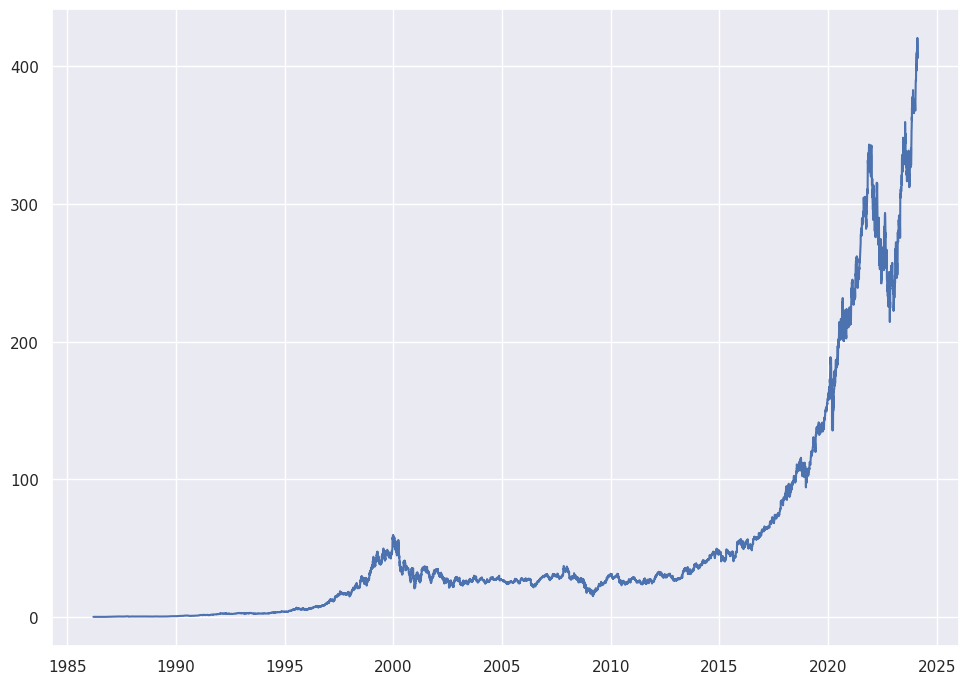

In [ ]:
plt.plot(volume_msft.index, volume_msft['Close'])

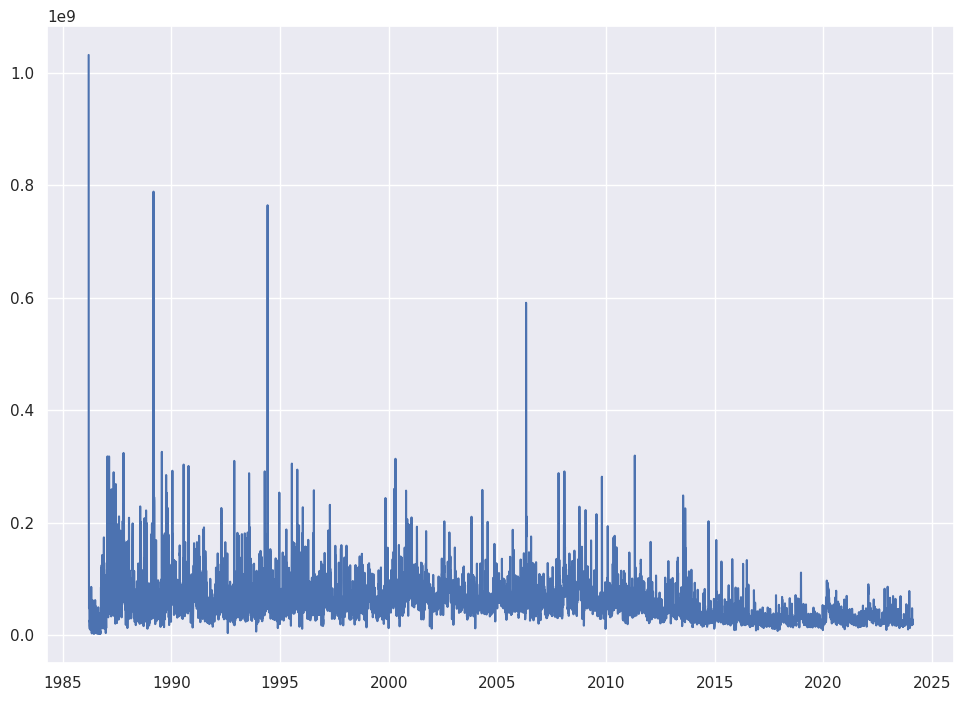

In [ ]:
plt.plot(volume_msft.index, volume_msft['Volume'])

removing the first day (IPO) volume

In [ ]:
volume_msft = volume_msft.iloc[1:]

reviewing the volume chart

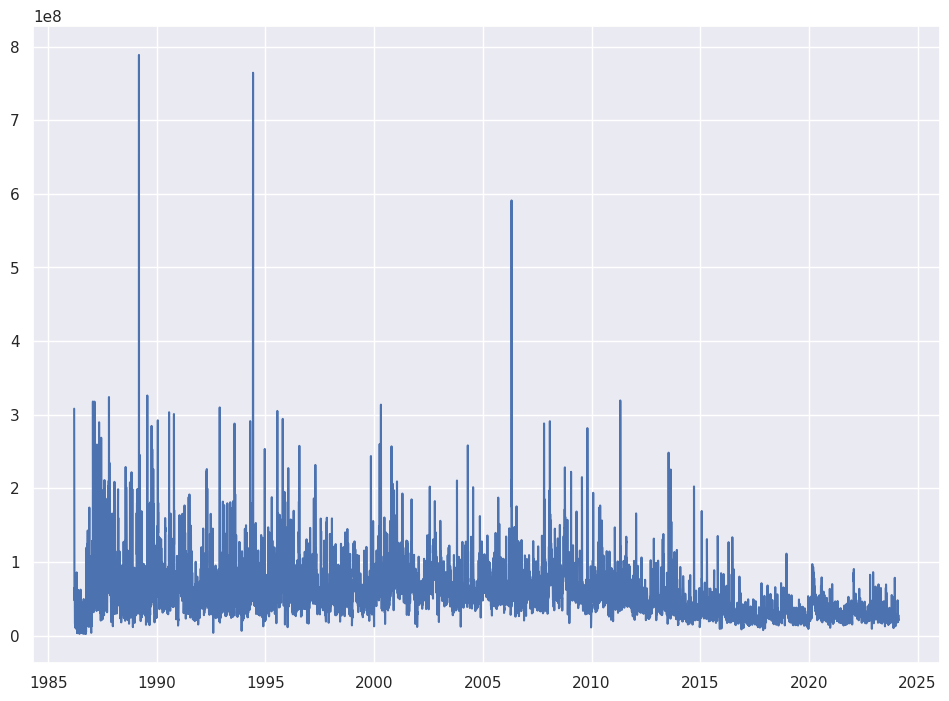

In [ ]:
plt.plot(volume_msft.index, volume_msft['Volume'])

In [ ]:
windowed_volume = volume_msft.filter(['Close', 'Volume'])

windowed_volume

,Close,Volume
Date,,
1986-03-14,0.100694,308160000
1986-03-17,0.102431,133171200
1986-03-18,0.099826,67766400
1986-03-19,0.098090,47894400
1986-03-20,0.095486,58435200
...,...,...
2024-02-09,420.549988,22032800
2024-02-12,415.260010,21202900
2024-02-13,406.320007,27824900


In [ ]:
missing_values = windowed_volume.isnull().sum()
print(missing_values)

Close     0
Volume    0
dtype: int64


In [ ]:
missing_values2 = windowed_volume.isna().sum()
print(missing_values2)

Close     0
Volume    0
dtype: int64


In [ ]:
windowed_volume_np = windowed_volume.values

windowed_volume_np

array([[1.00694000e-01, 3.08160000e+08],
       [1.02431000e-01, 1.33171200e+08],
       [9.98260000e-02, 6.77664000e+07],
       ...,
       [4.06320007e+02, 2.78249000e+07],
       [4.09489990e+02, 2.04012000e+07],
       [4.06559998e+02, 2.18040000e+07]])

In [ ]:
training_volume_len = math.ceil(len(windowed_volume_np) * .8)
val_volume_len = math.ceil(len(windowed_volume_np) * .9)


training_volume_data = windowed_volume_np[0:training_volume_len, :]
val_volume_data = windowed_volume_np[training_volume_len:val_volume_len, :]
test_volume_data = windowed_volume_np[val_volume_len:, :]
x_train_vol = []
y_train_vol = []
x_val_vol = []
y_val_vol = []
x_test_vol = []
y_test_vol = []


for i in range(3, len(training_volume_data)):
  x_train_vol.append(training_volume_data[i-3:i])
  y_train_vol.append(training_volume_data[i, 0])
  if i <= 3:
    print(x_train_vol)
    print(y_train_vol)
    print()

for i in range(3, len(val_volume_data)):
  x_val_vol.append(val_volume_data[i-3:i])
  y_val_vol.append(val_volume_data[i, 0])

for i in range(3,len(test_data)):
  x_test_vol.append(test_volume_data[i-3:i])
  y_test_vol.append(test_volume_data[i, 0])

[array([[1.006940e-01, 3.081600e+08],
       [1.024310e-01, 1.331712e+08],
       [9.982600e-02, 6.776640e+07]])]
[0.09809]



In [ ]:
print(x_val_vol)
print(y_val_vol)

[array([[5.3740002e+01, 2.4545500e+07],
       [5.3700001e+01, 3.2024400e+07],
       [5.3959999e+01, 3.1433900e+07]]), array([[5.3700001e+01, 3.2024400e+07],
       [5.3959999e+01, 3.1433900e+07],
       [5.3090000e+01, 5.3336500e+07]]), array([[5.3959999e+01, 3.1433900e+07],
       [5.3090000e+01, 5.3336500e+07],
       [5.5910000e+01, 8.9893300e+07]]), array([[5.3090000e+01, 5.3336500e+07],
       [5.5910000e+01, 8.9893300e+07],
       [5.5799999e+01, 3.2776700e+07]]), array([[5.5910000e+01, 8.9893300e+07],
       [5.5799999e+01, 3.2776700e+07],
       [5.6570000e+01, 3.2157200e+07]]), array([[5.5799999e+01, 3.2776700e+07],
       [5.6570000e+01, 3.2157200e+07],
       [5.6730000e+01, 2.5610600e+07]]), array([[5.6570000e+01, 3.2157200e+07],
       [5.6730000e+01, 2.5610600e+07],
       [5.6759998e+01, 2.8079000e+07]]), array([[5.6730000e+01, 2.5610600e+07],
       [5.6759998e+01, 2.8079000e+07],
       [5.6189999e+01, 3.2327500e+07]]), array([[5.6759998e+01, 2.8079000e+07],
       [

In [ ]:
print(x_test_vol)
print(y_test_vol)

[array([[1.74570007e+02, 3.93705000e+07],
       [1.78839996e+02, 3.03729000e+07],
       [1.80759995e+02, 3.68392000e+07]]), array([[1.78839996e+02, 3.03729000e+07],
       [1.80759995e+02, 3.68392000e+07],
       [1.82539993e+02, 3.21393000e+07]]), array([[1.80759995e+02, 3.68392000e+07],
       [1.82539993e+02, 3.21393000e+07],
       [1.83600006e+02, 2.83160000e+07]]), array([[1.82539993e+02, 3.21393000e+07],
       [1.83600006e+02, 2.83160000e+07],
       [1.84679993e+02, 3.08778000e+07]]), array([[1.83600006e+02, 2.83160000e+07],
       [1.84679993e+02, 3.08778000e+07],
       [1.86740005e+02, 3.08927000e+07]]), array([[1.84679993e+02, 3.08778000e+07],
       [1.86740005e+02, 3.08927000e+07],
       [1.82509995e+02, 3.20382000e+07]]), array([[1.86740005e+02, 3.08927000e+07],
       [1.82509995e+02, 3.20382000e+07],
       [1.79750000e+02, 4.47115000e+07]]), array([[1.82509995e+02, 3.20382000e+07],
       [1.79750000e+02, 4.47115000e+07],
       [1.80529999e+02, 4.18739000e+07]]),

In [ ]:
x_train_vol, y_train_vol = np.array(x_train_vol), np.array(y_train_vol)
x_val_vol, y_val_vol = np.array(x_val_vol), np.array(y_val_vol)
x_test_vol, y_test_vol = np.array(x_test_vol), np.array(y_test_vol)

In [ ]:
x_train_vol.shape

(7644, 3, 2)

In [ ]:
print(x_train_vol.shape)
print(y_train_vol.shape)

(7644, 3, 2)
(7644,)


In [ ]:
model_2.fit(x_train_vol, y_train_vol, validation_data=(x_val_vol, y_val_vol), epochs= 100)

Epoch 1/100
239/239 [==============================] - 1s 5ms/step - loss: 241.4386 - mean_absolute_error: 13.4672 - val_loss: 7980.9360 - val_mean_absolute_error: 82.7602
Epoch 2/100
239/239 [==============================] - 1s 5ms/step - loss: 239.3710 - mean_absolute_error: 13.4388 - val_loss: 7903.3604 - val_mean_absolute_error: 82.2901
Epoch 3/100
239/239 [==============================] - 1s 5ms/step - loss: 239.1787 - mean_absolute_error: 13.4562 - val_loss: 7643.8052 - val_mean_absolute_error: 80.6977
Epoch 4/100
239/239 [==============================] - 1s 5ms/step - loss: 239.5440 - mean_absolute_error: 13.4539 - val_loss: 7802.0806 - val_mean_absolute_error: 81.6725
Epoch 5/100
239/239 [==============================] - 1s 5ms/step - loss: 238.9097 - mean_absolute_error: 13.4529 - val_loss: 7301.8501 - val_mean_absolute_error: 78.5504
Epoch 6/100
239/239 [==============================] - 1s 5ms/step - loss: 239.2183 - mean_absolute_error: 13.4382 - val_loss: 7663.1699 - v

**NEW MODEL ARCHITECTURE**

In [ ]:

model_3 = Sequential()
model_3.add(LSTM(64, return_sequences= True, input_shape = (3, 1)))
model_3.add(LSTM(64))
model_3.add(Dense(32, activation='relu'))
model_3.add(Dense(32, activation='relu'))
model_3.add(Dense(1))

model_3.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error']
              )



applying the model 3 on msftx, taking close price only,
3 days input 1 day output

In [ ]:
x_train_model3 = x_train
y_train_model3 = y_train
x_val_model3 = x_val
y_val_model3 = y_val

model_3.fit(x_train_model3, y_train_model3, validation_data=(x_val_model3, y_val_model3), epochs= 100)

Epoch 1/100
227/227 [==============================] - 5s 10ms/step - loss: 90.2235 - mean_absolute_error: 4.4461 - val_loss: 479.3909 - val_mean_absolute_error: 14.8645
Epoch 2/100
227/227 [==============================] - 2s 8ms/step - loss: 0.4625 - mean_absolute_error: 0.3997 - val_loss: 392.9238 - val_mean_absolute_error: 12.8758
Epoch 3/100
227/227 [==============================] - 2s 8ms/step - loss: 0.4512 - mean_absolute_error: 0.4039 - val_loss: 351.9901 - val_mean_absolute_error: 11.8726
Epoch 4/100
227/227 [==============================] - 2s 8ms/step - loss: 0.3953 - mean_absolute_error: 0.3743 - val_loss: 328.8336 - val_mean_absolute_error: 11.1774
Epoch 5/100
227/227 [==============================] - 2s 8ms/step - loss: 0.3322 - mean_absolute_error: 0.3416 - val_loss: 308.6231 - val_mean_absolute_error: 10.6300
Epoch 6/100
227/227 [==============================] - 2s 8ms/step - loss: 0.3466 - mean_absolute_error: 0.3526 - val_loss: 296.9578 - val_mean_absolute_error

Model 4,
7 days input, 1 day output,
trying different structures


In [ ]:
windowed_df_7_1 = df_to_windowed_df(df_msftx,
                                '1986-03-24',
                                '2022-03-23',
                                n=7)
windowed_df_7_1

,Target Date,Target-7,Target-6,Target-5,Target-4,Target-3,Target-2,Target-1,Target
0,1986-03-24,0.097222,0.100694,0.102431,0.099826,0.098090,0.095486,0.092882,0.090278
1,1986-03-25,0.100694,0.102431,0.099826,0.098090,0.095486,0.092882,0.090278,0.092014
2,1986-03-26,0.102431,0.099826,0.098090,0.095486,0.092882,0.090278,0.092014,0.094618
3,1986-03-27,0.099826,0.098090,0.095486,0.092882,0.090278,0.092014,0.094618,0.096354
4,1986-03-31,0.098090,0.095486,0.092882,0.090278,0.092014,0.094618,0.096354,0.095486
...,...,...,...,...,...,...,...,...,...
9070,2022-03-17,275.850006,288.500000,285.589996,280.070007,276.440002,287.149994,294.390015,295.220001
9071,2022-03-18,288.500000,285.589996,280.070007,276.440002,287.149994,294.390015,295.220001,300.429993
9072,2022-03-21,285.589996,280.070007,276.440002,287.149994,294.390015,295.220001,300.429993,299.160004
9073,2022-03-22,280.070007,276.440002,287.149994,294.390015,295.220001,300.429993,299.160004,304.059998


In [ ]:
dates_7_1, x_7_1, y_7_1 = windowed_df_to_date_X_y(windowed_df_7_1)

dates_7_1.shape, x_7_1.shape, y_7_1.shape

((9075,), (9075, 7, 1), (9075,))

In [ ]:
q_7_1_80 = int(len(dates_7_1)* 0.8)
q_7_1_90 = int(len(dates_7_1)* 0.9)

dates_7_1_train, x_7_1_train, y_7_1_train = dates_7_1[:q_80], x_7_1[:q_80], y_7_1[:q_80]
dates_7_1_val, x_7_1_val, y_7_1_val = dates_7_1[q_80:q_90], x_7_1[q_80:q_90], y_7_1[q_80:q_90]
dates_7_1_test, x_7_1_test, y_7_1_test = dates_7_1[q_90:], x_7_1[q_90:], y_7_1[q_90:]

In [ ]:
model_4 = Sequential()
#when i put return_sequences=false it works best 8%, when i remove it, it's good 10%, when i put return_sequences=true accuracy is 45%
model_4.add(LSTM(64, return_sequences= False, input_shape = (7, 1)))
model_4.add(Dense(32, activation='relu'))
model_4.add(Dense(32, activation='relu'))
model_4.add(Dense(1))

model_4.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error']
              )


In [ ]:
model_4.fit(x_7_1_train, y_7_1_train, validation_data=(x_7_1_val, y_7_1_val), epochs= 100)

Epoch 1/100
227/227 [==============================] - 4s 10ms/step - loss: 73.9149 - mean_absolute_error: 3.5199 - val_loss: 599.6139 - val_mean_absolute_error: 16.3278
Epoch 2/100
227/227 [==============================] - 2s 8ms/step - loss: 0.4068 - mean_absolute_error: 0.3506 - val_loss: 474.4708 - val_mean_absolute_error: 13.6538
Epoch 3/100
227/227 [==============================] - 2s 8ms/step - loss: 0.3768 - mean_absolute_error: 0.3651 - val_loss: 422.3048 - val_mean_absolute_error: 12.4827
Epoch 4/100
227/227 [==============================] - 2s 8ms/step - loss: 0.3214 - mean_absolute_error: 0.3328 - val_loss: 389.5780 - val_mean_absolute_error: 11.7732
Epoch 5/100
227/227 [==============================] - 2s 8ms/step - loss: 0.3030 - mean_absolute_error: 0.3204 - val_loss: 364.2340 - val_mean_absolute_error: 11.3439
Epoch 6/100
227/227 [==============================] - 2s 7ms/step - loss: 0.2907 - mean_absolute_error: 0.3097 - val_loss: 352.0188 - val_mean_absolute_error

Model 5, 30 days input, 1 day output, trying different structures

In [ ]:
windowed_df_30_1 = df_to_windowed_df(df_msftx,
                                '1986-04-25',
                                '2022-03-23',
                                n=30)
windowed_df_30_1

,Target Date,Target-30,Target-29,Target-28,Target-27,Target-26,Target-25,Target-24,Target-23,Target-22,...,Target-9,Target-8,Target-7,Target-6,Target-5,Target-4,Target-3,Target-2,Target-1,Target
0,1986-04-25,0.097222,0.100694,0.102431,0.099826,0.098090,0.095486,0.092882,0.090278,0.092014,...,0.100694,0.100694,0.104167,0.105035,0.101563,0.101563,0.099826,0.100260,0.110243,0.117188
1,1986-04-28,0.100694,0.102431,0.099826,0.098090,0.095486,0.092882,0.090278,0.092014,0.094618,...,0.100694,0.104167,0.105035,0.101563,0.101563,0.099826,0.100260,0.110243,0.117188,0.118056
2,1986-04-29,0.102431,0.099826,0.098090,0.095486,0.092882,0.090278,0.092014,0.094618,0.096354,...,0.104167,0.105035,0.101563,0.101563,0.099826,0.100260,0.110243,0.117188,0.118056,0.114583
3,1986-04-30,0.099826,0.098090,0.095486,0.092882,0.090278,0.092014,0.094618,0.096354,0.095486,...,0.105035,0.101563,0.101563,0.099826,0.100260,0.110243,0.117188,0.118056,0.114583,0.111979
4,1986-05-01,0.098090,0.095486,0.092882,0.090278,0.092014,0.094618,0.096354,0.095486,0.094618,...,0.101563,0.101563,0.099826,0.100260,0.110243,0.117188,0.118056,0.114583,0.111979,0.110243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9047,2022-03-17,313.459991,301.250000,305.940002,300.950012,304.559998,311.209991,302.380005,295.040009,295.000000,...,289.859985,278.910004,275.850006,288.500000,285.589996,280.070007,276.440002,287.149994,294.390015,295.220001
9048,2022-03-18,301.250000,305.940002,300.950012,304.559998,311.209991,302.380005,295.040009,295.000000,300.470001,...,278.910004,275.850006,288.500000,285.589996,280.070007,276.440002,287.149994,294.390015,295.220001,300.429993
9049,2022-03-21,305.940002,300.950012,304.559998,311.209991,302.380005,295.040009,295.000000,300.470001,299.500000,...,275.850006,288.500000,285.589996,280.070007,276.440002,287.149994,294.390015,295.220001,300.429993,299.160004
9050,2022-03-22,300.950012,304.559998,311.209991,302.380005,295.040009,295.000000,300.470001,299.500000,290.730011,...,288.500000,285.589996,280.070007,276.440002,287.149994,294.390015,295.220001,300.429993,299.160004,304.059998


In [ ]:
dates_30_1, x_30_1, y_30_1 = windowed_df_to_date_X_y(windowed_df_30_1)

dates_30_1.shape, x_30_1.shape, y_30_1.shape

((9052,), (9052, 30, 1), (9052,))

In [ ]:
q_30_1_80 = int(len(dates_30_1)* 0.8)
q_30_1_90 = int(len(dates_30_1)* 0.9)

dates_30_1_train, x_30_1_train, y_30_1_train = dates_30_1[:q_80], x_30_1[:q_80], y_30_1[:q_80]
dates_30_1_val, x_30_1_val, y_30_1_val = dates_30_1[q_80:q_90], x_30_1[q_80:q_90], y_30_1[q_80:q_90]
dates_30_1_test, x_30_1_test, y_30_1_test = dates_30_1[q_90:], x_30_1[q_90:], y_30_1[q_90:]

In [ ]:
model_5 = Sequential()
model_5.add(LSTM(64, return_sequences= True, input_shape = (30, 1)))
model_5.add(LSTM(64, return_sequences= False))
model_5.add(Dense(32, activation='relu'))
model_5.add(Dense(32, activation='relu'))
model_5.add(Dense(1))

model_5.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error']
              )

In [ ]:
model_5.fit(x_30_1_train, y_30_1_train, validation_data=(x_30_1_val, y_30_1_val), epochs= 100)

Epoch 1/100
227/227 [==============================] - 11s 34ms/step - loss: 88.2846 - mean_absolute_error: 4.1792 - val_loss: 754.3776 - val_mean_absolute_error: 20.0998
Epoch 2/100
227/227 [==============================] - 7s 32ms/step - loss: 0.8641 - mean_absolute_error: 0.5322 - val_loss: 591.7800 - val_mean_absolute_error: 16.5180
Epoch 3/100
227/227 [==============================] - 7s 30ms/step - loss: 0.5676 - mean_absolute_error: 0.4424 - val_loss: 507.9865 - val_mean_absolute_error: 14.8002
Epoch 4/100
227/227 [==============================] - 7s 29ms/step - loss: 0.4984 - mean_absolute_error: 0.4269 - val_loss: 470.1013 - val_mean_absolute_error: 14.1463
Epoch 5/100
227/227 [==============================] - 7s 30ms/step - loss: 0.4515 - mean_absolute_error: 0.4170 - val_loss: 422.4651 - val_mean_absolute_error: 12.9732
Epoch 6/100
227/227 [==============================] - 7s 30ms/step - loss: 0.3913 - mean_absolute_error: 0.3826 - val_loss: 388.8122 - val_mean_absolute

Model 6, 360 days input, 1 day output, trying different *structures*

In [ ]:
windowed_df_360_1 = df_to_windowed_df(df_msftx,
                                '1987-08-14',
                                '2022-03-23',
                                n=360)
windowed_df_360_1

NameError: name 'df_to_windowed_df' is not defined

In [ ]:
dates_360_1, x_360_1, y_360_1 = windowed_df_to_date_X_y(windowed_df_360_1)

dates_360_1.shape, x_360_1.shape, y_360_1.shape

((8722,), (8722, 360, 1), (8722,))

In [ ]:
q_360_1_80 = int(len(dates_360_1)* 0.8)
q_360_1_90 = int(len(dates_360_1)* 0.9)

dates_360_1_train, x_360_1_train, y_360_1_train = dates_360_1[:q_80], x_360_1[:q_80], y_360_1[:q_80]
dates_360_1_val, x_360_1_val, y_360_1_val = dates_360_1[q_80:q_90], x_360_1[q_80:q_90], y_360_1[q_80:q_90]
dates_360_1_test, x_360_1_test, y_360_1_test = dates_360_1[q_90:], x_360_1[q_90:], y_360_1[q_90:]

In [ ]:
model_6 = Sequential()
model_6.add(LSTM(360, return_sequences= True, input_shape = (360, 1)))
model_6.add(LSTM(256))
model_6.add(Dense(128, activation='relu'))
model_6.add(Dense(64, activation='relu'))
model_6.add(Dense(32, activation='relu'))
model_6.add(Dense(1))

model_6.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error']
              )

In [ ]:
model_6.fit(x_360_1_train, y_360_1_train, validation_data=(x_360_1_val, y_360_1_val), epochs= 100)

Epoch 1/100
227/227 [==============================] - 383s 2s/step - loss: 0.8832 - mean_absolute_error: 0.6307 - val_loss: 1908.1818 - val_mean_absolute_error: 33.7142
Epoch 2/100
118/227 [==============>...............] - ETA: 2:43 - loss: 0.5348 - mean_absolute_error: 0.4652

KeyboardInterrupt: 

In [ ]:
model_6_2 = Sequential([layers.Input((360,1)),
                    layers.LSTM(360),
                    layers.Dense(128, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)
                    ])

model_6_2.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error']
              )



In [ ]:
model_6_2.fit(x_360_1_train, y_360_1_train, validation_data=(x_360_1_val, y_360_1_val), epochs= 100)

In [ ]:
model_6_3 = Sequential()
model_6_3.add(LSTM(360, return_sequences= True, input_shape = (360, 1)))
model_6_3.add(LSTM(256, return_sequences= True,))
model_6_3.add(LSTM(256))
model_6_3.add(Dense(256, activation='relu'))
model_6_3.add(Dense(256, activation='relu'))
model_6_3.add(Dense(64, activation='relu'))
model_6_3.add(Dense(32, activation='relu'))
model_6_3.add(Dense(1))

model_6_3.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error']
              )

In [ ]:
model_6_3.fit(x_360_1_train, y_360_1_train, validation_data=(x_360_1_val, y_360_1_val), epochs= 100)

In [ ]:
model_6_4 = Sequential()
model_6_4.add(LSTM(360, return_sequences= True, input_shape = (360, 1)))
model_6_4.add(Dense(128, activation='relu'))
model_6_4.add(Dense(64, activation='relu'))
model_6_4.add(Dense(32, activation='relu'))
model_6_4.add(Dense(1))

model_6_4.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error']
              )

In [ ]:
model_6_4.fit(x_360_1_train, y_360_1_train, validation_data=(x_360_1_val, y_360_1_val), epochs= 100)

Model 7, 360 days input, 30 days output, trying different structures

In [ ]:
windowed_df_360_7 = df_msftx.values
windowed_df_360_7

In [ ]:
windowed_df_360_7.shape

In [ ]:
windowed_df_360_7[361]

In [ ]:
training_len_360_7 = math.ceil(len(windowed_df_360_7) * .8)
val_len_360_7 = math.ceil(len(windowed_df_360_7) * .9)


training_data_360_7 = windowed_df_360_7[0:training_len_360_7, :]
val_data_360_7 = windowed_df_360_7[training_len_360_7:val_len_360_7, :]
test_data_360_7 = windowed_df_360_7[val_len_360_7:, :]
x_train_360_7 = []
y_train_360_7 = []
x_val_360_7 = []
y_val_360_7 = []
x_test_360_7 = []
y_test_360_7 = []


for i in range(360, len(training_data_360_7)):
  x_train_360_7.append(training_data_360_7[i-360:i, :])

  y_train_360_7.append(training_data_360_7[i-30:i, 0])
  if i <= 360:
    print(x_train_360_7)
    print(y_train_360_7)
    print()

for i in range(360, len(val_data_360_7)):
  x_val_360_7.append(val_data_360_7[i-360:i, i:i+30])
  y_val_360_7.append(val_data_360_7[i-30:i, 0])

for i in range(360,len(test_data_360_7)):
  x_test_360_7.append(test_data_360_7[i-360:i, i:i+30])
  y_test_360_7.append(test_data_360_7[i-30:i, 0])

In [ ]:
x_train_360_7, y_train_360_7 = np.array(x_train_360_7), np.array(y_train_360_7)
x_val_360_7, y_val_360_7 = np.array(x_val_360_7), np.array(y_val_360_7)
x_test_360_7, y_test_360_7 = np.array(x_test_360_7), np.array(y_test_360_7)

In [ ]:
x_train_360_7.shape

In [ ]:
y_train_360_7.shape

In [ ]:
model_7_1 = Sequential()
model_7_1.add(LSTM(360, input_shape = (360, 1)))
model_7_1.add(Dense(128, activation='relu'))
model_7_1.add(Dense(32, activation='relu'))
model_7_1.add(Dense(30))

model_7_1.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error']
              )

In [ ]:
model_7_1.fit(x_train_360_7, y_train_360_7, validation_data=(x_val_360_7, y_val_360_7), epochs= 100)

Apple prediction

Create dataset with date and close price only

In [ ]:
df_aapl

In [ ]:
df_aaplx = df_aapl[['Date', 'Close']]

df_aaplx

In [ ]:
df_aapl['Date']

In [ ]:
datetime_object_aapl = str_to_datetime('1980-12-12')
datetime_object_aapl

In [ ]:
df_aapl

In [ ]:
df_aapl['Date'] = df_aapl['Date'].apply(str_to_datetime)
df_aapl['Date']

Replacing the index with the date column

In [ ]:
df_aapl.index = df_aapl.pop('Date')
df_aapl

In [ ]:
plt.plot(df_aapl.index, df_aapl['Close'])

In [ ]:

# Start day first time: '1986-03-18'
windowed_df_aapl = df_to_windowed_df(df_aapl,
                                '1986-03-18',
                                '2024-02-23',
                                n=3)
windowed_df_aapl

In [ ]:
dates_aapl, X_aapl, y_aapl = windowed_df_to_date_X_y(windowed_df_aapl)

dates_aapl.shape, X_aapl.shape, y_aapl.shape

In [ ]:
q_aapl_80 = int(len(dates_aapl)* 0.8)
q_aapl_90 = int(len(dates_aapl)* 0.9)

dates_aapl_train, X_aapl_train, y_aapl_train = dates_aapl[:q_aapl_80], X_aapl[:q_aapl_80], y_aapl[:q_aapl_80]
dates_aapl_val, X_aapl_val, y_aapl_val = dates_aapl[q_aapl_80:q_aapl_90], X_aapl[q_aapl_80:q_aapl_90], y_aapl[q_aapl_80:q_aapl_90]
dates_aapl_test, X_aapl_test, y_aapl_test = dates_aapl[q_aapl_90:], X_aapl[q_aapl_90:], y_aapl[q_aapl_90:]

In [ ]:
plt.plot(dates_aapl_train,y_aapl_train)
plt.plot(dates_aapl_val,y_aapl_val)
plt.plot(dates_aapl_test,y_aapl_test)
plt.legend(['Train', 'Validation', 'Test'])

In [ ]:
model_aapl = Sequential([layers.Input((3,1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)
                    ])
model_aapl.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error']
              )

model_aapl.fit(X_aapl_train, y_aapl_train, validation_data=(X_aapl_val, y_aapl_val), epochs= 100)

In [ ]:
train_aapl_predictions = model_aapl.predict(X_aapl_train).flatten()

plt.plot(dates_aapl_train, train_aapl_predictions)
plt.plot(dates_aapl_train, y_aapl_train)
plt.legend(['Apple Training Predictions', 'Apple Training Observations'])

In [ ]:
val_aapl_predictions = model_aapl.predict(X_aapl_val).flatten()

plt.plot(dates_aapl_val, val_aapl_predictions)
plt.plot(dates_aapl_val, y_aapl_val)
plt.legend(['Apple Validation Predictions', 'Apple Validation Observations'])

In [ ]:
test_aapl_predictions = model_aapl.predict(X_aapl_test).flatten()

plt.plot(dates_aapl_test, test_aapl_predictions)
plt.plot(dates_aapl_test, y_aapl_test)
plt.legend(['Apple Testing Predictions', 'Apple Testing Observations'])

In [ ]:
plt.plot(dates_aapl_train, train_aapl_predictions)
plt.plot(dates_aapl_train, y_aapl_train)
plt.plot(dates_aapl_val, val_aapl_predictions)
plt.plot(dates_aapl_val, y_aapl_val)
plt.plot(dates_aapl_test, test_aapl_predictions)
plt.plot(dates_aapl_test, y_aapl_test)
plt.legend(['Apple Training Predictions',
            'Apple Training Observations',
            'Apple Validation Predictions',
            'Apple Validation Observations',
            'Apple Testing Predictions',
            'Apple Testing Observations'])